**Deep Learning Final Project**

**DeepFace:** Closing the Gap to Human-Level Performance in Face Verification [DOI](http://doi.org/10.1109/CVPR.2014.220)

This project focuses on an paper published in 2014 which presented a deep learning network for facial regocnision.

Researchers (Facebook and University of Tel Aviv) set out to explore if and how deep learning, and specifically locally connected layers, could reach human level accuracy of 97%. They used a private, extrememly large dataset, containing 4M images of 4K identities. With a network that learned 120M different parameters, without any use of feature engineering.

The two main contributions of this paper were:


1.   Normalization and localization of the face as preperation for the learning and prediction process
2.   An accurate, human level performance, deep learning architecture as a replacement for SVM methods that were common accross the Computer Vision (CV) community up to that point

Our target for this project is to try and replicate that process, and try to offer different approaches to further improve the network. Due to the limited data and computational resources an exact replication of results could not be reached, therefore we've set a new process which was aligned with our instructor. The process below was also presented in class:


1.   Succesfully implement the network from the paper reaching an acceptable accuracy level according to data and hardware (HW) limitations
2.   Present changes and modification that could either shorten learning time and/or increase accuracy on the same exact data

This project is divided as followed:


*   Presenting and visualizing the dataset
*   Implementation of the network in the paper
*   Initial results which were also covered in our class presentation
*   Data manipulation and adjustments to reach the first target listed above
*   Changes in the network
*   Results and conclusions
*   Discussion and future improvements

*At the bottom of this notebok there's a section for assistive methods which were used for data preperation or visualizatoin. In order to help keep this paper as short and to the point as possible. All methods are kept as an Appendix at the end.

**We've ran parts of this code both on Colab and SageMaker, therefore some methods and paths for directories are different and might not work on a specific inviornment.





# Libraries and Installations

In [ ]:
# install Augmentor for the dataset preperations
!pip install Augmentor

In [ ]:
# Setup of all needed libraries
%matplotlib inline
import os
import sys
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import gdown
import zipfile
import os
from IPython.display import Image, display
import cv2
import random

import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.nn.modules.utils import _pair

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision

from PIL import Image
import torch.nn as nn

import Augmentor
import shutil
from pathlib import Path
from tqdm import tqdm
from tqdm.auto import tqdm
from torch.utils.data.dataset import random_split
import torch.nn.functional as F

seed = 118 # initialize random seed, 118 is my squadron number in the army :)
torch.manual_seed(seed)

In [ ]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/anaustinbeing/haar-cascade-files/master/haarcascade_frontalface_alt2.xml

--2024-03-28 15:50:52--  https://raw.githubusercontent.com/anaustinbeing/haar-cascade-files/master/haarcascade_frontalface_alt2.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540616 (528K) [text/plain]
Saving to: ‘haarcascade_frontalface_alt2.xml’

haarcascade_frontal 100%[===================>] 527.95K  --.-KB/s    in 0.01s   

2024-03-28 15:50:52 (34.4 MB/s) - ‘haarcascade_frontalface_alt2.xml’ saved [540616/540616]



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Preperations of data**

Data was downloaded from Kaggle directly to google drive and could be found at https://www.kaggle.com/datasets/jessicali9530/lfw-dataset/data

Basic information on how the data is split

In [ ]:
data_df = data_review('/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled')

In [ ]:
# Number of classes
len(data_df.index)

5749

In [ ]:
# Number of images
data_df['Number of Images'].sum()

13233

In [ ]:
# Class with max number of images
data_df.sort_values(by='Number of Images', ascending=False).head(1)

,Class Name,Number of Images
1871,George_W_Bush,530


In [ ]:
frequency_df = data_frequency(data_df)

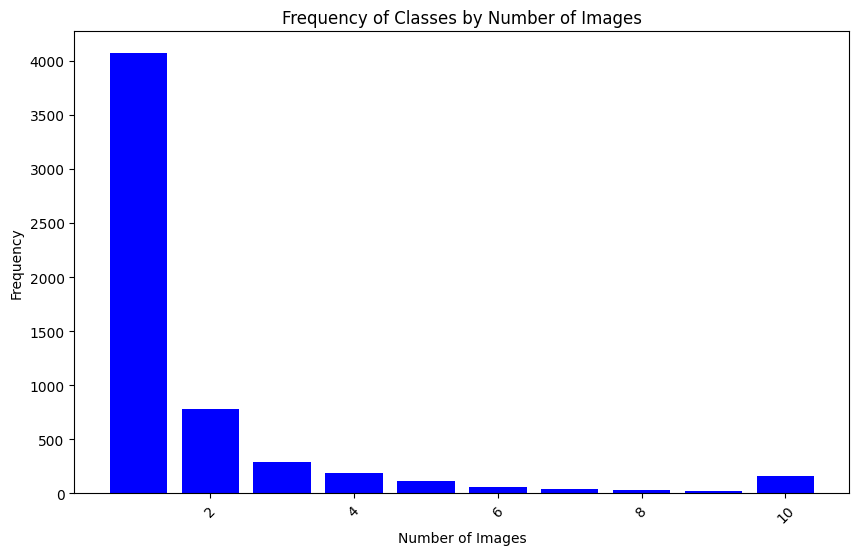

In [ ]:
# Bar chart to display number of images per class

plt.figure(figsize=(10, 6))
plt.bar(frequency_df['Number of Images'], frequency_df['Frequency'], color='blue')

plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Frequency of Classes by Number of Images')

plt.xticks(rotation=45)

plt.show()

In [ ]:
# Number of classes with 1-5 images and the top classes with most images
pd.concat([frequency_df.head(5), frequency_df.tail(5)])

,Number of Images,Frequency
0,1,4069
1,2,779
2,3,291
3,4,187
4,5,112
48,109,1
49,121,1
50,144,1
51,236,1
52,530,1


Generated with chat GPT ([link](https://chat.openai.com/share/5b439d06-218b-4951-b3a9-38ecc039b656))

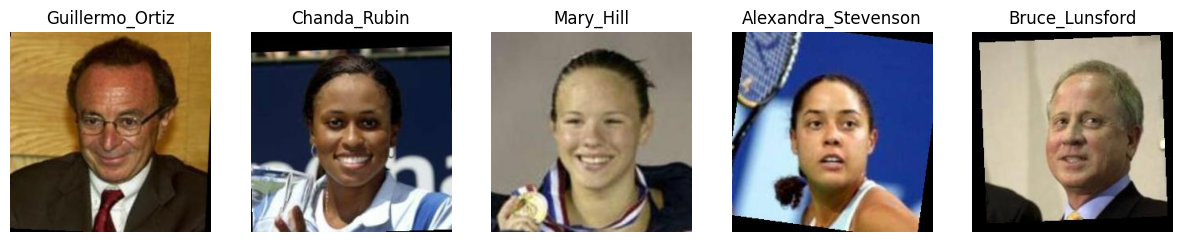

In [ ]:
# Sample images

# Generated using chatGPT

# Path to the main directory
dir_path = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled'

# Get a list of all subdirectories
sub_dirs = [os.path.join(dir_path, o) for o in os.listdir(dir_path)
            if os.path.isdir(os.path.join(dir_path,o))]

# Select five random subdirectories
random_sub_dirs = random.sample(sub_dirs, 5)

# Initialize a list to store paths of random images and their respective subdirectory names
random_images = []

# For each selected subdirectory, pick one random image
for sub_dir in random_sub_dirs:
    images = os.listdir(sub_dir)
    random_image = random.choice(images)
    random_images.append((sub_dir, os.path.join(sub_dir, random_image)))

# Display the images with their class name
plt.figure(figsize=(15, 3))
for i, (sub_dir, img_path) in enumerate(random_images, 1):
    img = Image.open(img_path)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(sub_dir.split('/')[-1])  # Extracts and displays the folder name as the title
    plt.axis('off')
plt.show()

**The dataset is not balaced**. During research this dataset was used for testing rather then training. We've seen that the images in the dataset are **alreayd aligned which is one of the the key parameters for implementation**.

# **Network Implementation**

## Defining the network

In [ ]:
# Defining the locally connected layers

class LocallyConnected2d(nn.Module):
  def __init__(self, in_channels, out_channels, output_size, kernel_size, stride, bias=True):
    super(LocallyConnected2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_size = output_size
    self.kernel_size = kernel_size
    self.stride = stride
    self.weight = nn.Parameter(
      torch.randn(out_channels, in_channels, output_size, output_size, kernel_size, kernel_size)) # initialize in N(0,1) as in the paper
    if bias:
      self.bias = nn.Parameter(
        torch.full((out_channels, output_size, output_size), 0.5) # The paper used bias of 0.5
      )
    else:
      self.register_parameter('bias', None)

  def forward(self, x):
    x = x.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride) # extracting all windows at the defined kernel size
    x = x.contiguous().view(*x.size()[:-2], -1)
    weight = self.weight.view(self.out_channels, self.in_channels, self.output_size, self.output_size, -1) # assign weight for each kernel seperately
    # Sum in in_channel and kernel_size dims
    out = (x.unsqueeze(1) * weight).sum([2, -1])
    if self.bias is not None:
      out = out.view(x.size(0), self.out_channels, self.output_size, self.output_size) + self.bias
    return out

In [ ]:
#Bulid the architecture - same as in the paper

class DeepFace(nn.Module):
  def __init__(self, num_classes):
    super(DeepFace,self).__init__()
    #input 152x152x3
    self.C1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=11, stride=1, padding=0),
                            nn.ReLU())
    self.M2=nn.Sequential(nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 0),
                          nn.ReLU())
    self.C3=nn.Sequential(nn.Conv2d(32, 16, kernel_size=9, stride=1, padding=0),
                          nn.ReLU())
    self.L4=nn.Sequential(LocallyConnected2d(16, 16, 54, kernel_size=9, stride=1),
                          nn.ReLU())
    self.L5=nn.Sequential(LocallyConnected2d(16, 16, 24, kernel_size=7, stride=2),
                          nn.ReLU())
    self.L6=nn.Sequential(LocallyConnected2d(16, 16, 20, kernel_size=5, stride=1),
                          nn.ReLU())
    self.flat=nn.Flatten()
    self.F7=nn.Sequential(nn.Linear(6400, 4096),
                          nn.ReLU(),
                          nn.Dropout(0.5))
    self.F8=nn.Sequential(nn.Linear(4096, num_classes))

  # Initialize weights as in the paper
  def _init_weights_and_biases(self):
    for module in self.modules():
      if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0, std=0.01)
        if module.bias is not None:
          nn.init.constant_(module.bias, 0.5)


  def forward(self, x):
    x=self.C1(x)
    #3x142x142
    x=self.M2(x)
    #3x70x70 (in the paper 3x71x71 due to rounding up)
    x=self.C3(x)
    #3x62x62 (in the paper 3x63x63)
    x=self.L4(x)
    #16x54x54 (in the paper 16x55x55)
    x=self.L5(x)
    #16x24x24 (in the paper #16x25x25)
    x=self.L6(x)
    #16x20x20 (in the paper #16x21x21)
    x=self.flat(x)
    x=self.F7(x)
    x=self.F8(x)
    return x

The network followed the paper with some minor adjustments in dimensions

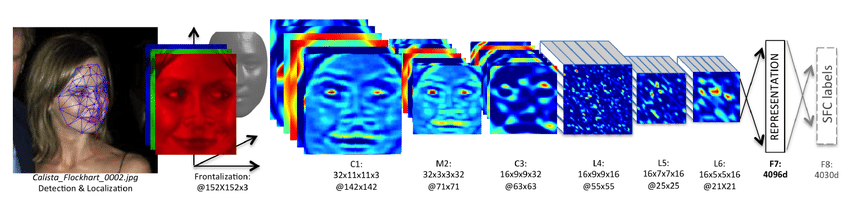

## Face detection and localization

Another aspect of the architecure was the frontalization and localization of faces. To tackle this, we've implemented a face detection algorithm that detects and resizes the face according to the requirement of 152*152

The algorithm is called Haarcascade, which is a Cascade Classifier and was taken from [link](https://www.geeksforgeeks.org/face-detection-using-cascade-classifier-using-opencv-python/). The code was adjusted to our needs of the network.

In [ ]:
def crop_face(img):

  img_array = np.array(img)
  # Convert into grayscale
  gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
  # Load the cascade
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  # In case we didn't find a face we'll still use the image but just resize it. Not ideal but managable
  if len(faces) == 0:
    img = cv2.resize(img_array, (152, 152))
    return Image.fromarray(img)
  elif len(faces) > 1: # in case there is more than one face, we want to pick the "biggest" one since this is how the dataset is made
    big_face = max(faces, key=lambda item: item[2] * item[3])
    faces = [big_face] # keep only one face from the image

  # Crop the face
  for (x, y, w, h) in faces:
    cv2.rectangle(img_array, (x, y), (x+w, y+h), (0, 0, 255), 2)
    face = img_array[y:y + h, x:x + w]
    resized_face = cv2.resize(face, (152, 152))

  return Image.fromarray(resized_face)

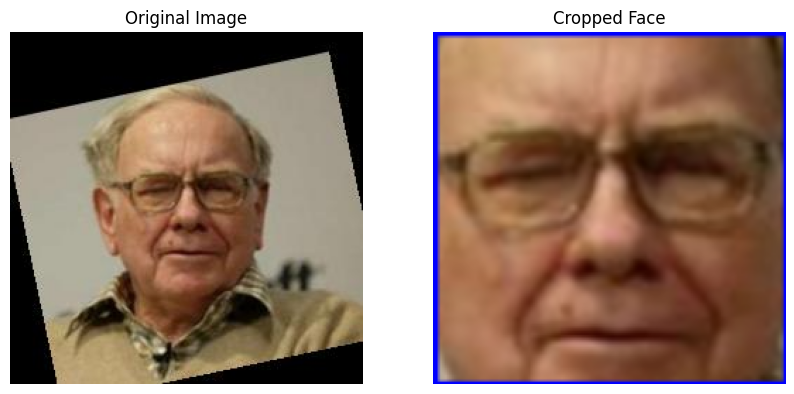

In [ ]:
# Test the method

original_image = cv2.imread('/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled/Warren_Buffett/Warren_Buffett_0003.jpg')
face_image = cv2.cvtColor(np.array(crop_face(face_image)), cv2.COLOR_BGR2RGB)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Plot the cropped image
ax[1].imshow(face_image)
ax[1].set_title('Cropped Face')
ax[1].axis('off')

plt.show()

## Data balancing

Next we had to choose how to treat the data. Our initial decision was to remove all classes with below three images, and normalize all classes to max of 10 images per class. This is due to the HW limitations and to not have an unbalansed dataset.

The methods used to divide the dataset are in the assistive methods section.

In [ ]:
# Call method to adjust data size per class
# Method to adjust data per class since some classes e.g. Gorge W Bush have extreme size of images compared to others that have only one
# This method sets a limit of 10 images per class and will reduce the entire dataset from ~13000 images to ~10500

adjust_image_data('/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled')

We now want to make a new dataset from all classes that have 3 to 10 images

In [ ]:
source_dir = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled'
target_dir = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset'
copy_directory_if_images_exceed(source_dir, target_dir, 3, 10) # copy from source to target all folders with 3-10 images

Copied directory: /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled/Aaron_Peirsol to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aaron_Peirsol
Copied directory: /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled/Abdoulaye_Wade to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdoulaye_Wade
Copied directory: /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled/Abdullah to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdullah
Copied directory: /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled/Abdullah_Gul to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdullah_Gul
Copied directory: /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/lfw-deepfunneled/Abdullah_al-Attiyah to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/sm

Let's go over the new dataset

In [ ]:
# Define the directory to iterate over
small_data_df = data_review('/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset')

In [ ]:
# Number of classes
len(small_data_df.index)

901

In [ ]:
# Number of images
small_data_df['Number of Images'].sum()

4862

In [ ]:
small_frequency_df = data_frequency(small_data_df)

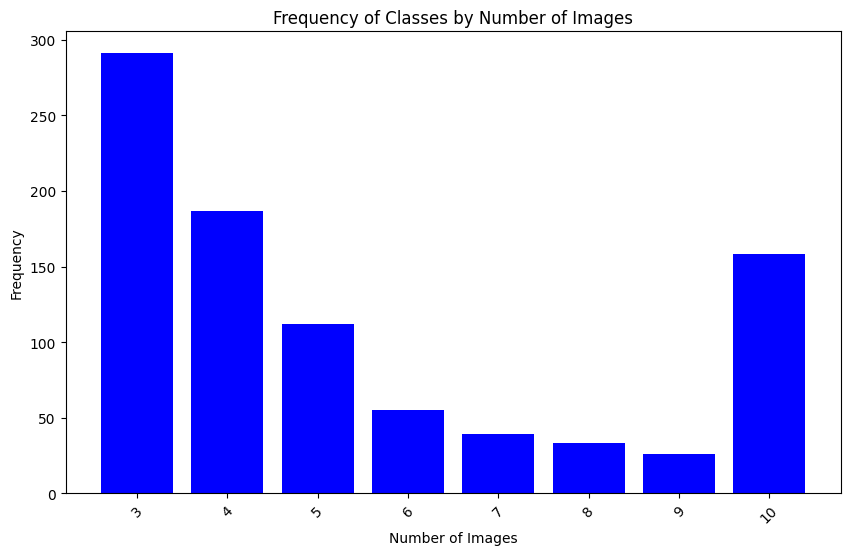

In [ ]:
# Bar chart to display number images per class

plt.figure(figsize=(10, 6))
plt.bar(small_frequency_df['Number of Images'], small_frequency_df['Frequency'], color='blue')

plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Frequency of Classes by Number of Images')

plt.xticks(rotation=45)

plt.show()

In [ ]:
small_frequency_df

,Number of Images,Frequency
0,3,291
1,4,187
2,5,112
3,6,55
4,7,39
5,8,33
6,9,26
7,10,158


## Augmentation

We now have 901 classes with a little under 5K images. Data is still not balanced enough, so we've added augmented versions of random images so each class will have at least five images. Followed by splitting the dataset into train and test. The process was implemented where we took the first image of each class to get a total of 901 test images. We did not accound for an "other" class and did not test images on classes we haven't trained on. This approach corresponds to what was done in the paper.

In [ ]:
# Call the method for testing
augment(1, '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aaron_Peirsol')

Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aaron_Peirsol.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955A182B0>: 100%|██████████| 1/1 [00:00<00:00, 57.53 Samples/s]


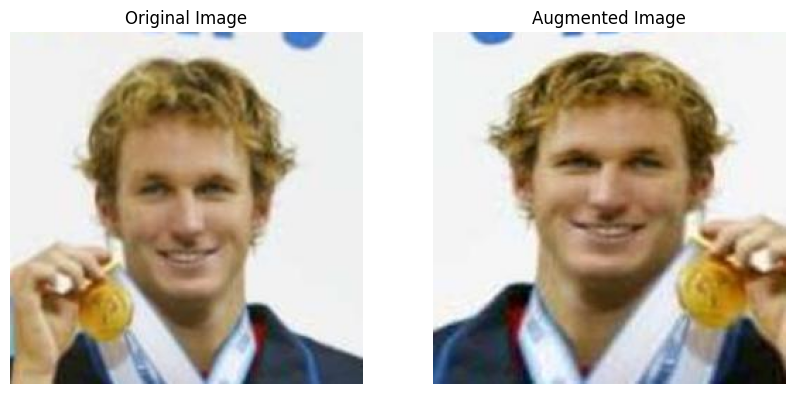

In [ ]:
# Example of augmentation

original_image = cv2.imread('/content/drive/MyDrive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aaron_Peirsol/Aaron_Peirsol_0001.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
augmented_image = cv2.imread('/content/drive/MyDrive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aaron_Peirsol/Aaron_Peirsol_original_Aaron_Peirsol_0001.jpg_dc00e675-cd91-49f7-b89a-37e1a4397443.jpg')
augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Plot the cropped image
ax[1].imshow(augmented_image)
ax[1].set_title('Augmented Image')
ax[1].axis('off')

plt.show()

In [ ]:
# we want to add additional images per class, we do this by augmenting random images from the same class
# the output is that each class will have 5-10 images that will be split for training and testing the network

# call augmenting method
dir = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset'

for root, dirs, files in os.walk(dir):
  # count number of images in the subfolder
  num_files = len([file for file in files if file.endswith(('jpg', 'png', 'jpeg'))])
  if num_files >= 5 or num_files == 0: # if we have at least 5 images we don't want to augment additional ones
    continue
  else:
    print(root)
    augment(5-num_files, root) # pass the directory + how many images we want to add in order to get a total of 5

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdoulaye_Wade
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdoulaye_Wade.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95578C430>: 100%|██████████| 1/1 [00:00<00:00, 34.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdullah
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdullah.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AA9B0>: 100%|██████████| 1/1 [00:00<00:00, 30.01 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdullah_al-Attiyah
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abdullah_al-Attiyah.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4C40>: 100%|██████████| 2/2 [00:00<00:00, 31.88 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abel_Pacheco
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abel_Pacheco.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA590>: 100%|██████████| 1/1 [00:00<00:00, 44.57 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abid_Hamid_Mahmud_Al-Tikriti
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Abid_Hamid_Mahmud_Al-Tikriti.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4D00>: 100%|██████████| 2/2 [00:00<00:00, 59.78 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Adam_Sandler
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Adam_Sandler.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FEE0>: 100%|██████████| 1/1 [00:00<00:00, 48.49 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Adel_Al-Jubeir
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Adel_Al-Jubeir.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EBA658211B0>: 100%|██████████| 2/2 [00:00<00:00, 59.32 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Adolfo_Aguilar_Zinser
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Adolfo_Aguilar_Zinser.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C53C0>: 100%|██████████| 2/2 [00:00<00:00, 31.72 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aicha_El_Ouafi


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aicha_El_Ouafi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C52D0>: 100%|██████████| 2/2 [00:00<00:00, 53.19 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Akbar_Hashemi_Rafsanjani
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Akbar_Hashemi_Rafsanjani.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4E80>: 100%|██████████| 2/2 [00:00<00:00, 43.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Akhmed_Zakayev
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Akhmed_Zakayev.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5390>: 100%|██████████| 2/2 [00:00<00:00, 43.94 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Al_Pacino


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Al_Pacino.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A3580>: 100%|██████████| 2/2 [00:00<00:00, 53.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alec_Baldwin
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alec_Baldwin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A3F40>: 100%|██████████| 1/1 [00:00<00:00, 26.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alejandro_Avila
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alejandro_Avila.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4DC0>: 100%|██████████| 2/2 [00:00<00:00, 62.97 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aleksander_Kwasniewski
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Aleksander_Kwasniewski.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955821390>: 100%|██████████| 1/1 [00:00<00:00, 85.03 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alex_Sink
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alex_Sink.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555365C0>: 100%|██████████| 2/2 [00:00<00:00, 67.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alexander_Downer
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alexander_Downer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DAAA0>: 100%|██████████| 1/1 [00:00<00:00, 57.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alexander_Losyukov
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alexander_Losyukov.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955820A00>: 100%|██████████| 1/1 [00:00<00:00, 62.37 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alexandra_Stevenson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alexandra_Stevenson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4DC0>: 100%|██████████| 2/2 [00:00<00:00, 69.20 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ali_Khamenei
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ali_Khamenei.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C49A0>: 100%|██████████| 2/2 [00:00<00:00, 66.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alvaro_Noboa
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alvaro_Noboa.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4A90>: 100%|██████████| 2/2 [00:00<00:00, 87.30 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alvaro_Silva_Calderon


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Alvaro_Silva_Calderon.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABD60>: 100%|██████████| 1/1 [00:00<00:00, 83.32 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Amanda_Bynes
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Amanda_Bynes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABFD0>: 100%|██████████| 1/1 [00:00<00:00, 55.44 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Amer_al-Saadi
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Amer_al-Saadi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555EB3A0>: 100%|██████████| 1/1 [00:00<00:00, 22.75 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anastasia_Myskina
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anastasia_Myskina.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C50C0>: 100%|██████████| 2/2 [00:00<00:00, 81.44 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anders_Ebbeson


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anders_Ebbeson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4B50>: 100%|██████████| 2/2 [00:00<00:00, 65.63 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anders_Fogh_Rasmussen
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anders_Fogh_Rasmussen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABD60>: 100%|██████████| 1/1 [00:00<00:00, 66.18 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Andrew_Weissmann
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Andrew_Weissmann.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4C40>: 100%|██████████| 2/2 [00:00<00:00, 83.60 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Angelo_Reyes
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Angelo_Reyes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABA00>: 100%|██████████| 1/1 [00:00<00:00, 39.12 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anibal_Ibarra


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anibal_Ibarra.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556C5450>: 100%|██████████| 2/2 [00:00<00:00, 70.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anne_Krueger
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anne_Krueger.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C41F0>: 100%|██████████| 2/2 [00:00<00:00, 90.88 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anne_McLellan
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Anne_McLellan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C53F0>: 100%|██████████| 2/2 [00:00<00:00, 56.94 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Annette_Lu


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Annette_Lu.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C54E0>: 100%|██████████| 2/2 [00:00<00:00, 53.67 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Antonio_Trillanes
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Antonio_Trillanes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C56C0>: 100%|██████████| 2/2 [00:00<00:00, 45.52 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Antony_Leung
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Antony_Leung.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4B50>: 100%|██████████| 1/1 [00:00<00:00, 47.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arianna_Huffington
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arianna_Huffington.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABA00>: 100%|██████████| 1/1 [00:00<00:00, 35.74 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arlen_Specter
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arlen_Specter.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5480>: 100%|██████████| 2/2 [00:00<00:00, 65.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arnold_Palmer
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arnold_Palmer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AA230>: 100%|██████████| 2/2 [00:00<00:00, 51.48 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Art_Howe
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Art_Howe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C48E0>: 100%|██████████| 1/1 [00:00<00:00, 51.64 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arturo_Gatti
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Arturo_Gatti.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C4280>: 100%|██████████| 2/2 [00:00<00:00, 68.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ashton_Kutcher
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ashton_Kutcher.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C41C0>: 100%|██████████| 2/2 [00:00<00:00, 85.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Augustin_Calleri
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Augustin_Calleri.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AA230>: 100%|██████████| 1/1 [00:00<00:00, 45.80 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Azra_Akin
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Azra_Akin.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556A3F10>: 100%|██████████| 1/1 [00:00<00:00, 86.34 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Barbara_Walters
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Barbara_Walters.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AB310>: 100%|██████████| 1/1 [00:00<00:00, 56.88 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Barbra_Streisand
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Barbra_Streisand.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5A20>: 100%|██████████| 2/2 [00:00<00:00, 46.43 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bashar_Assad
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bashar_Assad.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95561FE50>: 100%|██████████| 1/1 [00:00<00:00, 43.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ben_Curtis
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ben_Curtis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5AE0>: 100%|██████████| 2/2 [00:00<00:00, 56.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ben_Howland
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ben_Howland.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C59C0>: 100%|██████████| 1/1 [00:00<00:00, 54.05 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bernard_Landry
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bernard_Landry.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5A20>: 100%|██████████| 1/1 [00:00<00:00, 43.09 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bijan_Darvish


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bijan_Darvish.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5BD0>: 100%|██████████| 2/2 [00:00<00:00, 72.38 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Biljana_Plavsic


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Biljana_Plavsic.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AB310>: 100%|██████████| 2/2 [00:00<00:00, 51.19 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bill_Callahan
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bill_Callahan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C41C0>: 100%|██████████| 2/2 [00:00<00:00, 85.69 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bill_Paxton
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bill_Paxton.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD60>: 100%|██████████| 1/1 [00:00<00:00, 68.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bob_Dole
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bob_Dole.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5C00>: 100%|██████████| 2/2 [00:00<00:00, 88.11 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bob_Huggins
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bob_Huggins.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95567BDF0>: 100%|██████████| 1/1 [00:00<00:00, 52.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bono
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bono.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5DE0>: 100%|██████████| 2/2 [00:00<00:00, 36.67 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Brad_Garrett
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Brad_Garrett.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955821360>: 100%|██████████| 1/1 [00:00<00:00, 43.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Branko_Crvenkovski
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Branko_Crvenkovski.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5720>: 100%|██████████| 2/2 [00:00<00:00, 85.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bridget_Fonda
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bridget_Fonda.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5C30>: 100%|██████████| 2/2 [00:00<00:00, 61.67 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bridgette_Wilson-Sampras
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bridgette_Wilson-Sampras.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5F90>: 100%|██████████| 2/2 [00:00<00:00, 63.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bruce_Springsteen
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bruce_Springsteen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5BD0>: 100%|██████████| 1/1 [00:00<00:00, 55.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bud_Selig
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Bud_Selig.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555D0730>: 100%|██████████| 1/1 [00:00<00:00, 59.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Candice_Bergen
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Candice_Bergen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5FF0>: 100%|██████████| 2/2 [00:00<00:00, 64.66 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Candie_Kung
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Candie_Kung.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5BD0>: 100%|██████████| 1/1 [00:00<00:00, 74.91 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlo_Ancelotti
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlo_Ancelotti.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9558C05B0>: 100%|██████████| 2/2 [00:00<00:00, 63.44 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Manuel_Pruneda
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Manuel_Pruneda.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C60B0>: 100%|██████████| 2/2 [00:00<00:00, 70.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Ortega
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Ortega.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5CC0>: 100%|██████████| 2/2 [00:00<00:00, 42.37 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Ruiz
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Ruiz.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5D50>: 100%|██████████| 2/2 [00:00<00:00, 53.62 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Vives
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carlos_Vives.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576EA70>: 100%|██████████| 1/1 [00:00<00:00, 43.48 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carly_Fiorina
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carly_Fiorina.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95567AB00>: 100%|██████████| 2/2 [00:00<00:00, 68.04 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carolina_Kluft
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carolina_Kluft.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5FC0>: 100%|██████████| 2/2 [00:00<00:00, 56.72 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Caroline_Kennedy
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Caroline_Kennedy.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5C90>: 100%|██████████| 2/2 [00:00<00:00, 42.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carolyn_Dawn_Johnson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carolyn_Dawn_Johnson.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556C5C30>: 100%|██████████| 2/2 [00:00<00:00, 80.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carson_Palmer
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Carson_Palmer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5D20>: 100%|██████████| 1/1 [00:00<00:00, 66.83 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cate_Blanchett
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cate_Blanchett.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5A20>: 100%|██████████| 1/1 [00:00<00:00, 43.45 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cecilia_Bolocco
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cecilia_Bolocco.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C61D0>: 100%|██████████| 2/2 [00:00<00:00, 70.47 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Chan_Gailey
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Chan_Gailey.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5B10>: 100%|██████████| 2/2 [00:00<00:00, 44.53 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Charles_Bronson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Charles_Bronson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C57E0>: 100%|██████████| 2/2 [00:00<00:00, 62.34 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cherie_Blair
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cherie_Blair.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555D0730>: 100%|██████████| 1/1 [00:00<00:00, 71.17 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Chick_Hearn
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Chick_Hearn.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C61D0>: 100%|██████████| 2/2 [00:00<00:00, 70.83 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christian_Longo
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christian_Longo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5A20>: 100%|██████████| 2/2 [00:00<00:00, 60.48 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christina_Aguilera
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christina_Aguilera.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABFD0>: 100%|██████████| 1/1 [00:00<00:00, 21.80 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christine_Gregoire
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christine_Gregoire.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABFD0>: 100%|██████████| 1/1 [00:00<00:00, 38.85 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christopher_Reeve
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christopher_Reeve.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABDF0>: 100%|██████████| 1/1 [00:00<00:00, 49.41 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christopher_Walken
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Christopher_Walken.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9558018A0>: 100%|██████████| 1/1 [00:00<00:00, 51.47 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cindy_Crawford
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Cindy_Crawford.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5E40>: 100%|██████████| 2/2 [00:00<00:00, 63.80 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Claire_Danes


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Claire_Danes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6170>: 100%|██████████| 2/2 [00:00<00:00, 73.93 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Clare_Short


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Clare_Short.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A2E00>: 100%|██████████| 1/1 [00:00<00:00, 46.32 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Claudia_Schiffer
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Claudia_Schiffer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C63B0>: 100%|██████████| 2/2 [00:00<00:00, 44.36 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Conan_OBrien
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Conan_OBrien.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5C90>: 100%|██████████| 1/1 [00:00<00:00, 48.90 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Conchita_Martinez
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Conchita_Martinez.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6410>: 100%|██████████| 2/2 [00:00<00:00, 58.56 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Constance_Marie
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Constance_Marie.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6320>: 100%|██████████| 2/2 [00:00<00:00, 63.36 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Coretta_Scott_King
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Coretta_Scott_King.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6500>: 100%|██████████| 2/2 [00:00<00:00, 37.60 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Daisy_Fuentes
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Daisy_Fuentes.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9557DA890>: 100%|██████████| 1/1 [00:00<00:00, 80.93 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dale_Earnhardt_Jr
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dale_Earnhardt_Jr.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555EB340>: 100%|██████████| 1/1 [00:00<00:00, 39.78 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dan_Morales
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dan_Morales.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5D50>: 100%|██████████| 2/2 [00:00<00:00, 73.08 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Daniel_Day-Lewis
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Daniel_Day-Lewis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6320>: 100%|██████████| 2/2 [00:00<00:00, 60.93 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Daniel_Radcliffe


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Daniel_Radcliffe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA9E0>: 100%|██████████| 1/1 [00:00<00:00, 40.23 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dave_Campo


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dave_Campo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555EB340>: 100%|██████████| 2/2 [00:00<00:00, 42.79 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/David_Caruso
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/David_Caruso.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6650>: 100%|██████████| 2/2 [00:00<00:00, 60.35 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/David_Hyde_Pierce
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/David_Hyde_Pierce.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5FF0>: 100%|██████████| 1/1 [00:00<00:00, 58.17 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/David_Stern
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/David_Stern.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D8FD0>: 100%|██████████| 1/1 [00:00<00:00, 50.32 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dean_Barkley


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dean_Barkley.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555372E0>: 100%|██████████| 1/1 [00:00<00:00, 76.58 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Debbie_Reynolds
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Debbie_Reynolds.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FEB0>: 100%|██████████| 1/1 [00:00<00:00, 80.27 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Debra_Messing
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Debra_Messing.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6560>: 100%|██████████| 2/2 [00:00<00:00, 64.29 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Demi_Moore
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Demi_Moore.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6470>: 100%|██████████| 1/1 [00:00<00:00, 71.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Derek_Jeter
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Derek_Jeter.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576E380>: 100%|██████████| 1/1 [00:00<00:00, 38.94 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Diana_Munz
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Diana_Munz.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6680>: 100%|██████████| 2/2 [00:00<00:00, 77.47 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dianne_Feinstein
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dianne_Feinstein.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6260>: 100%|██████████| 2/2 [00:00<00:00, 78.67 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dick_Clark


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Dick_Clark.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5C90>: 100%|██████████| 2/2 [00:00<00:00, 38.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Don_Siegelman
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Don_Siegelman.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6530>: 100%|██████████| 1/1 [00:00<00:00, 71.77 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Donald_Fehr
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Donald_Fehr.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C64A0>: 100%|██████████| 1/1 [00:00<00:00, 38.53 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Donald_Pettit
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Donald_Pettit.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555365C0>: 100%|██████████| 2/2 [00:00<00:00, 61.59 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Donatella_Versace
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Donatella_Versace.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C65C0>: 100%|██████████| 2/2 [00:00<00:00, 93.86 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Doris_Roberts
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Doris_Roberts.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6140>: 100%|██████████| 2/2 [00:00<00:00, 47.12 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Doris_Schroeder
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Doris_Schroeder.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5420>: 100%|██████████| 1/1 [00:00<00:00, 93.97 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Doug_Melvin
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Doug_Melvin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6980>: 100%|██████████| 2/2 [00:00<00:00, 59.27 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ed_Rosenthal
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ed_Rosenthal.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C64A0>: 100%|██████████| 2/2 [00:00<00:00, 72.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ed_Smart
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ed_Smart.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6830>: 100%|██████████| 2/2 [00:00<00:00, 59.24 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edmund_Hillary
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edmund_Hillary.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6470>: 100%|██████████| 2/2 [00:00<00:00, 54.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edward_Kennedy
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edward_Kennedy.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6620>: 100%|██████████| 2/2 [00:00<00:00, 72.57 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edwin_Edwards
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edwin_Edwards.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6620>: 100%|██████████| 2/2 [00:00<00:00, 50.83 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edwina_Currie
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Edwina_Currie.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555372E0>: 100%|██████████| 1/1 [00:00<00:00, 45.91 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Eileen_Coparropa
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Eileen_Coparropa.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6AD0>: 100%|██████████| 2/2 [00:00<00:00, 73.98 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Elena_Bovina
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Elena_Bovina.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6BC0>: 100%|██████████| 2/2 [00:00<00:00, 60.33 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Eliane_Karp
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Eliane_Karp.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6B60>: 100%|██████████| 1/1 [00:00<00:00, 69.22 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Elijah_Wood
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Elijah_Wood.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6D10>: 100%|██████████| 2/2 [00:00<00:00, 82.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Elizabeth_Dole
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Elizabeth_Dole.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6A40>: 100%|██████████| 1/1 [00:00<00:00, 42.15 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Emma_Thompson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Emma_Thompson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6BF0>: 100%|██████████| 2/2 [00:00<00:00, 63.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Emmanuelle_Beart
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Emmanuelle_Beart.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6D10>: 100%|██████████| 2/2 [00:00<00:00, 48.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Eric_Robert_Rudolph
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Eric_Robert_Rudolph.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5FF0>: 100%|██████████| 2/2 [00:00<00:00, 83.62 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Erik_Morales
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Erik_Morales.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6200>: 100%|██████████| 2/2 [00:00<00:00, 52.77 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Erin_Runnion
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Erin_Runnion.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6A70>: 100%|██████████| 1/1 [00:00<00:00, 53.27 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ernie_Els
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ernie_Els.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AA230>: 100%|██████████| 1/1 [00:00<00:00, 44.86 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ethan_Hawke


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ethan_Hawke.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6CE0>: 100%|██████████| 1/1 [00:00<00:00, 28.96 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Evan_Rachel_Wood
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Evan_Rachel_Wood.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C5A20>: 100%|██████████| 2/2 [00:00<00:00, 69.43 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fabrice_Santoro
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fabrice_Santoro.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6BC0>: 100%|██████████| 2/2 [00:00<00:00, 61.18 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Farouk_al-Sharaa
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Farouk_al-Sharaa.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6D40>: 100%|██████████| 2/2 [00:00<00:00, 71.66 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Faye_Dunaway
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Faye_Dunaway.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6AD0>: 100%|██████████| 2/2 [00:00<00:00, 61.89 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fayssal_Mekdad
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fayssal_Mekdad.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6CB0>: 100%|██████████| 1/1 [00:00<00:00, 53.12 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Federico_Trillo


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Federico_Trillo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6740>: 100%|██████████| 2/2 [00:00<00:00, 62.96 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Felipe_Perez_Roque


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Felipe_Perez_Roque.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D8FD0>: 100%|██████████| 1/1 [00:00<00:00, 47.20 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fernando_Vargas
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fernando_Vargas.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576F8E0>: 100%|██████████| 1/1 [00:00<00:00, 48.40 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Filippo_Inzaghi
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Filippo_Inzaghi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576E470>: 100%|██████████| 2/2 [00:00<00:00, 63.52 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Francisco_Flores


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Francisco_Flores.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6140>: 100%|██████████| 1/1 [00:00<00:00, 30.03 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Frank_Cassell
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Frank_Cassell.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6A10>: 100%|██████████| 2/2 [00:00<00:00, 67.29 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Franz_Fischler
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Franz_Fischler.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6B30>: 100%|██████████| 1/1 [00:00<00:00, 48.53 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Franz_Muentefering
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Franz_Muentefering.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6740>: 100%|██████████| 1/1 [00:00<00:00, 37.13 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fred_Eckhard
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fred_Eckhard.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6BC0>: 100%|██████████| 2/2 [00:00<00:00, 57.77 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fred_Thompson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Fred_Thompson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C61D0>: 100%|██████████| 2/2 [00:00<00:00, 76.51 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/GL_Peiris
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/GL_Peiris.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD90>: 100%|██████████| 1/1 [00:00<00:00, 38.35 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gary_Carter
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gary_Carter.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6A40>: 100%|██████████| 2/2 [00:00<00:00, 71.88 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gary_Doer
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gary_Doer.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556C6A10>: 100%|██████████| 2/2 [00:00<00:00, 63.85 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Galloway
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Galloway.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576F8E0>: 100%|██████████| 1/1 [00:00<00:00, 47.82 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Papandreou


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Papandreou.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD60>: 100%|██████████| 1/1 [00:00<00:00, 54.64 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Ryan


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Ryan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95567AB00>: 100%|██████████| 1/1 [00:00<00:00, 49.90 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Voinovich


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/George_Voinovich.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6AD0>: 100%|██████████| 2/2 [00:00<00:00, 70.94 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Geraldine_Chaplin


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Geraldine_Chaplin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA9E0>: 100%|██████████| 1/1 [00:00<00:00, 38.19 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gian_Marco
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gian_Marco.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95561EDA0>: 100%|██████████| 2/2 [00:00<00:00, 48.86 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gianna_Angelopoulos-Daskalaki
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gianna_Angelopoulos-Daskalaki.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955821390>: 100%|██████████| 2/2 [00:00<00:00, 49.26 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gilberto_Rodriguez_Orejuela
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gilberto_Rodriguez_Orejuela.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6D10>: 100%|██████████| 1/1 [00:00<00:00, 78.86 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Giuseppe_Gibilisco
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Giuseppe_Gibilisco.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD60>: 100%|██████████| 1/1 [00:00<00:00, 41.12 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Glafcos_Clerides
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Glafcos_Clerides.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB95576E380>: 100%|██████████| 1/1 [00:00<00:00, 89.43 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gloria_Trevi


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gloria_Trevi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6C20>: 100%|██████████| 1/1 [00:00<00:00, 45.11 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Greg_Rusedski
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Greg_Rusedski.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6A40>: 100%|██████████| 1/1 [00:00<00:00, 84.15 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Guillermo_Canas
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Guillermo_Canas.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6D40>: 100%|██████████| 1/1 [00:00<00:00, 58.28 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gus_Van_Sant
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gus_Van_Sant.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6FB0>: 100%|██████████| 2/2 [00:00<00:00, 46.74 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gustavo_Kuerten


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gustavo_Kuerten.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6EF0>: 100%|██████████| 2/2 [00:00<00:00, 42.05 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gwendal_Peizerat
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Gwendal_Peizerat.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D9030>: 100%|██████████| 2/2 [00:00<00:00, 62.01 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hans_Eichel


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hans_Eichel.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6FE0>: 100%|██████████| 2/2 [00:00<00:00, 55.43 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Harry_Schmidt


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Harry_Schmidt.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6890>: 100%|██████████| 1/1 [00:00<00:00, 59.96 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heath_Ledger
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heath_Ledger.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6CE0>: 100%|██████████| 1/1 [00:00<00:00, 32.01 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heather_Mills
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heather_Mills.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6BC0>: 100%|██████████| 1/1 [00:00<00:00, 69.24 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hector_Babenco


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hector_Babenco.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6A70>: 100%|██████████| 2/2 [00:00<00:00, 57.65 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hee-Won_Han


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hee-Won_Han.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6DA0>: 100%|██████████| 2/2 [00:00<00:00, 59.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heidi_Fleiss
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heidi_Fleiss.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABDF0>: 100%|██████████| 1/1 [00:00<00:00, 12.91 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heinz_Feldmann
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Heinz_Feldmann.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6C50>: 100%|██████████| 2/2 [00:00<00:00, 58.22 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Helen_Clark
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Helen_Clark.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C67A0>: 100%|██████████| 1/1 [00:00<00:00, 25.57 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Herb_Sendek
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Herb_Sendek.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576EA70>: 100%|██████████| 1/1 [00:00<00:00, 45.63 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hilary_Duff
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hilary_Duff.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C70D0>: 100%|██████████| 2/2 [00:00<00:00, 53.04 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hipolito_Mejia
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hipolito_Mejia.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576E380>: 100%|██████████| 1/1 [00:00<00:00, 40.75 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Horst_Koehler
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Horst_Koehler.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C6FB0>: 100%|██████████| 2/2 [00:00<00:00, 74.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hun_Sen
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Hun_Sen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C70A0>: 100%|██████████| 1/1 [00:00<00:00, 57.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Iain_Duncan_Smith
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Iain_Duncan_Smith.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555AA230>: 100%|██████████| 1/1 [00:00<00:00, 26.87 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ian_McKellen


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ian_McKellen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C72E0>: 100%|██████████| 2/2 [00:00<00:00, 75.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ilan_Ramon
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ilan_Ramon.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C65F0>: 100%|██████████| 2/2 [00:00<00:00, 54.49 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Intisar_Ajouri
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Intisar_Ajouri.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C65F0>: 100%|██████████| 2/2 [00:00<00:00, 70.98 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Isabella_Rossellini
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Isabella_Rossellini.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955A18C40>: 100%|██████████| 2/2 [00:00<00:00, 30.99 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jack_Nicholson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jack_Nicholson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C73A0>: 100%|██████████| 2/2 [00:00<00:00, 37.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Caan
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Caan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7670>: 100%|██████████| 2/2 [00:00<00:00, 50.71 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Cameron
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Cameron.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7940>: 100%|██████████| 2/2 [00:00<00:00, 46.94 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Cunningham
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Cunningham.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA6B0>: 100%|██████████| 2/2 [00:00<00:00, 39.66 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Gandolfini
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Gandolfini.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7A90>: 100%|██████████| 2/2 [00:00<00:00, 55.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Kopp
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Kopp.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C73D0>: 100%|██████████| 1/1 [00:00<00:00, 54.56 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_McGreevey
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_McGreevey.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7550>: 100%|██████████| 1/1 [00:00<00:00, 68.79 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Traficant
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/James_Traficant.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7940>: 100%|██████████| 2/2 [00:00<00:00, 39.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jan-Michael_Gambill
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jan-Michael_Gambill.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D9030>: 100%|██████████| 2/2 [00:00<00:00, 68.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Janet_Napolitano
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Janet_Napolitano.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7670>: 100%|██████████| 1/1 [00:00<00:00, 32.70 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Javier_Weber
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Javier_Weber.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7220>: 100%|██████████| 2/2 [00:00<00:00, 38.30 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jay_Leno


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jay_Leno.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7970>: 100%|██████████| 2/2 [00:00<00:00, 43.75 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jayson_Williams


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jayson_Williams.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7C40>: 100%|██████████| 2/2 [00:00<00:00, 65.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jean-Francois_Pontal
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jean-Francois_Pontal.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7B20>: 100%|██████████| 2/2 [00:00<00:00, 46.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jeff_Van_Gundy
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jeff_Van_Gundy.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7CA0>: 100%|██████████| 2/2 [00:00<00:00, 31.47 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jennifer_Connelly
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jennifer_Connelly.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA6B0>: 100%|██████████| 1/1 [00:00<00:00, 24.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jennifer_Keller
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jennifer_Keller.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7580>: 100%|██████████| 1/1 [00:00<00:00, 35.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jerry_Regier
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jerry_Regier.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95578C4C0>: 100%|██████████| 1/1 [00:00<00:00, 42.24 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jerry_Springer
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jerry_Springer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A2E00>: 100%|██████████| 1/1 [00:00<00:00, 33.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jesse_Harris
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jesse_Harris.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7DF0>: 100%|██████████| 2/2 [00:00<00:00, 65.80 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jesse_Ventura
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jesse_Ventura.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7AC0>: 100%|██████████| 2/2 [00:00<00:00, 49.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_Carrey
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_Carrey.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576EB60>: 100%|██████████| 2/2 [00:00<00:00, 43.90 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_Hahn
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_Hahn.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95561EDA0>: 100%|██████████| 1/1 [00:00<00:00, 40.58 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_OBrien
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_OBrien.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC160>: 100%|██████████| 2/2 [00:00<00:00, 45.41 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_Tressel
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jim_Tressel.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A3F40>: 100%|██████████| 1/1 [00:00<00:00, 26.09 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jodie_Foster
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jodie_Foster.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC1F0>: 100%|██████████| 2/2 [00:00<00:00, 43.58 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joe_Nichols
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joe_Nichols.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC310>: 100%|██████████| 1/1 [00:00<00:00, 33.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joe_Torre
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joe_Torre.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC3A0>: 100%|██████████| 1/1 [00:00<00:00, 26.03 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Malkovich
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Malkovich.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC550>: 100%|██████████| 2/2 [00:00<00:00, 45.56 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Mayer
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Mayer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC2B0>: 100%|██████████| 2/2 [00:00<00:00, 38.80 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Reid
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Reid.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7A00>: 100%|██████████| 2/2 [00:00<00:00, 41.29 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Rosa
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Rosa.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCA00>: 100%|██████████| 2/2 [00:00<00:00, 31.83 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Swofford
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Swofford.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC7C0>: 100%|██████████| 2/2 [00:00<00:00, 35.52 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Warner
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/John_Warner.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD60>: 100%|██████████| 1/1 [00:00<00:00, 27.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Johnny_Tapia
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Johnny_Tapia.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC9D0>: 100%|██████████| 2/2 [00:00<00:00, 41.57 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jon_Corzine
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jon_Corzine.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC190>: 100%|██████████| 2/2 [00:00<00:00, 36.32 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jon_Voight
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jon_Voight.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC700>: 100%|██████████| 2/2 [00:00<00:00, 40.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jong_Wook_Lee
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jong_Wook_Lee.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC820>: 100%|██████████| 1/1 [00:00<00:00, 54.67 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jorge_Batlle
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jorge_Batlle.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCC40>: 100%|██████████| 2/2 [00:00<00:00, 68.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jose_Canseco
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jose_Canseco.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCDC0>: 100%|██████████| 2/2 [00:00<00:00, 58.24 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jose_Sarney
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Jose_Sarney.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCB50>: 100%|██████████| 2/2 [00:00<00:00, 67.31 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joseph_Deiss
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joseph_Deiss.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCA60>: 100%|██████████| 2/2 [00:00<00:00, 48.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joseph_Estrada
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Joseph_Estrada.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FC970>: 100%|██████████| 1/1 [00:00<00:00, 38.51 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Juan_Ignacio_Chela
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Juan_Ignacio_Chela.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556FCB80>: 100%|██████████| 2/2 [00:00<00:00, 58.78 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Juan_Manuel_Marquez


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Juan_Manuel_Marquez.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCAC0>: 100%|██████████| 2/2 [00:00<00:00, 57.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Juanes
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Juanes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCD90>: 100%|██████████| 2/2 [00:00<00:00, 70.03 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Julia_Tymoshenko
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Julia_Tymoshenko.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCEB0>: 100%|██████████| 2/2 [00:00<00:00, 36.76 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Justin_Guarini
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Justin_Guarini.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD0F0>: 100%|██████████| 2/2 [00:00<00:00, 58.15 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Justin_Leonard
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Justin_Leonard.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576EB60>: 100%|██████████| 1/1 [00:00<00:00, 64.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Justine_Henin
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Justine_Henin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD060>: 100%|██████████| 2/2 [00:00<00:00, 52.92 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kate_Winslet
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kate_Winslet.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD90>: 100%|██████████| 1/1 [00:00<00:00, 39.62 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Katherine_Harris
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Katherine_Harris.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FCC70>: 100%|██████████| 1/1 [00:00<00:00, 39.56 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kathleen_Kennedy_Townsend


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kathleen_Kennedy_Townsend.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD060>: 100%|██████████| 1/1 [00:00<00:00, 34.98 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Katie_Harman
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Katie_Harman.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD120>: 100%|██████████| 2/2 [00:00<00:00, 47.88 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Keith_Bogans
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Keith_Bogans.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD420>: 100%|██████████| 2/2 [00:00<00:00, 67.44 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kelly_Clarkson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kelly_Clarkson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD450>: 100%|██████████| 2/2 [00:00<00:00, 42.38 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kelvin_Sampson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kelvin_Sampson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD7B0>: 100%|██████████| 2/2 [00:00<00:00, 50.20 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kemal_Dervis
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kemal_Dervis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD1E0>: 100%|██████████| 2/2 [00:00<00:00, 50.54 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ken_Macha
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ken_Macha.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7EB0>: 100%|██████████| 2/2 [00:00<00:00, 51.22 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kenneth_Bowersox
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kenneth_Bowersox.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD6C0>: 100%|██████████| 2/2 [00:00<00:00, 76.53 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kim_Jong-Il
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kim_Jong-Il.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7DC0>: 100%|██████████| 1/1 [00:00<00:00, 31.19 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kim_Yong-il
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kim_Yong-il.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556C7DF0>: 100%|██████████| 2/2 [00:00<00:00, 59.32 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kimi_Raikkonen
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kimi_Raikkonen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD420>: 100%|██████████| 2/2 [00:00<00:00, 51.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kirk_Johnson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kirk_Johnson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7F40>: 100%|██████████| 2/2 [00:00<00:00, 64.27 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kjell_Magne_Bondevik


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kjell_Magne_Bondevik.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD930>: 100%|██████████| 2/2 [00:00<00:00, 61.57 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kobe_Bryant
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kobe_Bryant.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDB70>: 100%|██████████| 2/2 [00:00<00:00, 46.24 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kristen_Breitweiser
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kristen_Breitweiser.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDC60>: 100%|██████████| 2/2 [00:00<00:00, 32.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kristin_Davis
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kristin_Davis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD7E0>: 100%|██████████| 2/2 [00:00<00:00, 52.27 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kwon_Yang-sook
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Kwon_Yang-sook.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9558018A0>: 100%|██████████| 2/2 [00:00<00:00, 54.80 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/LK_Advani


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/LK_Advani.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDF00>: 100%|██████████| 2/2 [00:00<00:00, 64.88 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Laila_Ali
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Laila_Ali.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDDB0>: 100%|██████████| 2/2 [00:00<00:00, 36.13 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Larry_Coker
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Larry_Coker.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDB70>: 100%|██████████| 1/1 [00:00<00:00, 46.74 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Larry_Ellison
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Larry_Ellison.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE020>: 100%|██████████| 2/2 [00:00<00:00, 61.90 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Larry_Thompson
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Larry_Thompson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D9030>: 100%|██████████| 1/1 [00:00<00:00, 32.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lars_Von_Trier
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lars_Von_Trier.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE050>: 100%|██████████| 2/2 [00:00<00:00, 38.98 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Laura_Linney
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Laura_Linney.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA9E0>: 100%|██████████| 1/1 [00:00<00:00, 26.08 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lee_Hoi-chang


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lee_Hoi-chang.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FD510>: 100%|██████████| 1/1 [00:00<00:00, 67.87 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lee_Soo-hyuck
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lee_Soo-hyuck.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDAB0>: 100%|██████████| 2/2 [00:00<00:00, 62.83 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lennox_Lewis
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lennox_Lewis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDD80>: 100%|██████████| 2/2 [00:00<00:00, 46.96 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lenny_Wilkens
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lenny_Wilkens.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDC00>: 100%|██████████| 2/2 [00:00<00:00, 48.20 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lesley_McCulloch
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lesley_McCulloch.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE0E0>: 100%|██████████| 2/2 [00:00<00:00, 37.05 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Leslie_Caldwell
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Leslie_Caldwell.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576F8E0>: 100%|██████████| 2/2 [00:00<00:00, 63.32 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Leszek_Miller
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Leszek_Miller.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE0E0>: 100%|██████████| 2/2 [00:00<00:00, 57.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Liam_Neeson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Liam_Neeson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE290>: 100%|██████████| 2/2 [00:00<00:00, 71.48 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lino_Oviedo
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lino_Oviedo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE500>: 100%|██████████| 2/2 [00:00<00:00, 75.62 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lisa_Marie_Presley
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lisa_Marie_Presley.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE4A0>: 100%|██████████| 1/1 [00:00<00:00, 28.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lou_Piniella
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lou_Piniella.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE380>: 100%|██████████| 2/2 [00:00<00:00, 55.04 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Luciano_Pavarotti
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Luciano_Pavarotti.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE4D0>: 100%|██████████| 2/2 [00:00<00:00, 59.30 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Luis_Figo
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Luis_Figo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA9E0>: 100%|██████████| 1/1 [00:00<00:00, 37.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lynn_Redgrave
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lynn_Redgrave.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE980>: 100%|██████████| 2/2 [00:00<00:00, 70.59 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lynne_Cheney
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Lynne_Cheney.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE8C0>: 100%|██████████| 2/2 [00:00<00:00, 31.95 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Madeleine_Albright


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Madeleine_Albright.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDEA0>: 100%|██████████| 2/2 [00:00<00:00, 55.90 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Magdalena_Maleeva
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Magdalena_Maleeva.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE800>: 100%|██████████| 2/2 [00:00<00:00, 57.54 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Makhdoom_Amin_Fahim


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Makhdoom_Amin_Fahim.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE860>: 100%|██████████| 2/2 [00:00<00:00, 64.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marat_Safin
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marat_Safin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FEA10>: 100%|██████████| 2/2 [00:00<00:00, 51.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marc_Grossman
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marc_Grossman.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FDD20>: 100%|██████████| 1/1 [00:00<00:00, 24.27 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marcelo_Ebrard


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marcelo_Ebrard.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FE1D0>: 100%|██████████| 2/2 [00:00<00:00, 55.61 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marcelo_Salas


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marcelo_Salas.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95578C430>: 100%|██████████| 2/2 [00:00<00:00, 82.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mariana_Pollack
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mariana_Pollack.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABA00>: 100%|██████████| 2/2 [00:00<00:00, 68.89 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mariangel_Ruiz_Torrealba
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mariangel_Ruiz_Torrealba.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FEB00>: 100%|██████████| 2/2 [00:00<00:00, 63.38 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marieta_Chrousala
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marieta_Chrousala.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF040>: 100%|██████████| 2/2 [00:00<00:00, 39.26 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mark_Gottfried
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mark_Gottfried.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF100>: 100%|██████████| 2/2 [00:00<00:00, 56.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mark_Richt
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mark_Richt.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF2B0>: 100%|██████████| 2/2 [00:00<00:00, 45.69 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mark_Wahlberg
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mark_Wahlberg.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABFD0>: 100%|██████████| 1/1 [00:00<00:00, 73.11 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martha_Burk
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martha_Burk.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576FD60>: 100%|██████████| 1/1 [00:00<00:00, 63.87 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martha_Lucia_Ramirez


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martha_Lucia_Ramirez.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D8FD0>: 100%|██████████| 1/1 [00:00<00:00, 31.18 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martin_Verkerk


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martin_Verkerk.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF400>: 100%|██████████| 2/2 [00:00<00:00, 57.03 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martina_Hingis
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Martina_Hingis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF700>: 100%|██████████| 2/2 [00:00<00:00, 54.97 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marty_Mornhinweg


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Marty_Mornhinweg.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF400>: 100%|██████████| 2/2 [00:00<00:00, 44.75 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary-Kate_Olsen
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary-Kate_Olsen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF490>: 100%|██████████| 2/2 [00:00<00:00, 53.70 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary_Carey
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary_Carey.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FED40>: 100%|██████████| 1/1 [00:00<00:00, 66.61 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary_Landrieu
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary_Landrieu.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FEEF0>: 100%|██████████| 2/2 [00:00<00:00, 65.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary_Steenburgen
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mary_Steenburgen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFAF0>: 100%|██████████| 2/2 [00:00<00:00, 60.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Masum_Turker
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Masum_Turker.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF970>: 100%|██████████| 2/2 [00:00<00:00, 59.88 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mathias_Reichhold


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mathias_Reichhold.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF3A0>: 100%|██████████| 2/2 [00:00<00:00, 57.92 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matt_Damon
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matt_Damon.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF0A0>: 100%|██████████| 1/1 [00:00<00:00, 44.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matt_Dillon
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matt_Dillon.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFC70>: 100%|██████████| 2/2 [00:00<00:00, 56.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matt_Doherty
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matt_Doherty.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557080A0>: 100%|██████████| 2/2 [00:00<00:00, 45.37 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matthew_Broderick
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Matthew_Broderick.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF5B0>: 100%|██████████| 1/1 [00:00<00:00, 44.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Megan_Mullally
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Megan_Mullally.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFC40>: 100%|██████████| 2/2 [00:00<00:00, 58.78 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Melanie_Griffith
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Melanie_Griffith.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFEB0>: 100%|██████████| 2/2 [00:00<00:00, 43.99 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mian_Khursheed_Mehmood_Kasuri
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mian_Khursheed_Mehmood_Kasuri.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFC40>: 100%|██████████| 1/1 [00:00<00:00, 40.51 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Ballack
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Ballack.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE50>: 100%|██████████| 2/2 [00:00<00:00, 40.15 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Caine


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Caine.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFC40>: 100%|██████████| 1/1 [00:00<00:00, 24.01 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Jordan
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Jordan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE80>: 100%|██████████| 1/1 [00:00<00:00, 45.61 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Moore
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Moore.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955708070>: 100%|██████████| 2/2 [00:00<00:00, 45.87 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Winterbottom
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michael_Winterbottom.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576EB60>: 100%|██████████| 2/2 [00:00<00:00, 57.07 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michelle_Pfeiffer
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Michelle_Pfeiffer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576E380>: 100%|██████████| 2/2 [00:00<00:00, 67.60 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mike_Tyson


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mike_Tyson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF910>: 100%|██████████| 1/1 [00:00<00:00, 41.50 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mikhail_Kasyanov
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mikhail_Kasyanov.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF640>: 100%|██████████| 1/1 [00:00<00:00, 37.66 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mikhail_Wehbe
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mikhail_Wehbe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A1060>: 100%|██████████| 1/1 [00:00<00:00, 39.26 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mikhail_Youzhny
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mikhail_Youzhny.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7FA0>: 100%|██████████| 2/2 [00:00<00:00, 38.39 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Milo_Djukanovic
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Milo_Djukanovic.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C3A0>: 100%|██████████| 2/2 [00:00<00:00, 41.89 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Milo_Maestrecampo
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Milo_Maestrecampo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C3D0>: 100%|██████████| 2/2 [00:00<00:00, 61.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mitchell_Daniels
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mitchell_Daniels.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE20>: 100%|██████████| 1/1 [00:00<00:00, 24.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mohammed_Baqir_al-Hakim
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mohammed_Baqir_al-Hakim.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C580>: 100%|██████████| 2/2 [00:00<00:00, 27.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Monica_Bellucci
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Monica_Bellucci.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFDC0>: 100%|██████████| 1/1 [00:00<00:00, 29.13 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Monica_Lewinsky
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Monica_Lewinsky.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C550>: 100%|██████████| 2/2 [00:00<00:00, 28.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Monique_Garbrecht-Enfeldt
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Monique_Garbrecht-Enfeldt.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C310>: 100%|██████████| 2/2 [00:00<00:00, 73.60 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Moshe_Katsav
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Moshe_Katsav.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFD90>: 100%|██████████| 1/1 [00:00<00:00, 39.99 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mukesh_Ambani
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Mukesh_Ambani.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C5E0>: 100%|██████████| 2/2 [00:00<00:00, 39.91 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nabil_Shaath
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nabil_Shaath.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C850>: 100%|██████████| 2/2 [00:00<00:00, 41.40 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nan_Wang
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nan_Wang.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFD90>: 100%|██████████| 1/1 [00:00<00:00, 39.54 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Naoto_Kan
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Naoto_Kan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFD00>: 100%|██████████| 1/1 [00:00<00:00, 44.36 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Natalie_Cole
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Natalie_Cole.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C790>: 100%|██████████| 2/2 [00:00<00:00, 42.77 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Natasha_McElhone
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Natasha_McElhone.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C730>: 100%|██████████| 2/2 [00:00<00:00, 61.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nathalie_Baye
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nathalie_Baye.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE20>: 100%|██████████| 1/1 [00:00<00:00, 48.55 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nelson_Mandela
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nelson_Mandela.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF940>: 100%|██████████| 1/1 [00:00<00:00, 40.79 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nicolas_Cage
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Nicolas_Cage.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFCA0>: 100%|██████████| 1/1 [00:00<00:00, 33.50 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Noah_Wyle
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Noah_Wyle.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CBB0>: 100%|██████████| 2/2 [00:00<00:00, 51.21 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Noelle_Bush
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Noelle_Bush.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7460>: 100%|██████████| 1/1 [00:00<00:00, 28.87 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Norodom_Sihanouk
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Norodom_Sihanouk.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CB20>: 100%|██████████| 2/2 [00:00<00:00, 57.34 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Omar_Sharif
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Omar_Sharif.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE80>: 100%|██████████| 1/1 [00:00<00:00, 31.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Oprah_Winfrey
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Oprah_Winfrey.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA860>: 100%|██████████| 1/1 [00:00<00:00, 24.69 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Orlando_Bloom


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Orlando_Bloom.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555ABBE0>: 100%|██████████| 2/2 [00:00<00:00, 89.02 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Osama_bin_Laden
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Osama_bin_Laden.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C760>: 100%|██████████| 1/1 [00:00<00:00, 26.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Oxana_Fedorova
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Oxana_Fedorova.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CBB0>: 100%|██████████| 1/1 [00:00<00:00, 70.35 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ozzy_Osbourne
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ozzy_Osbourne.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF0A0>: 100%|██████████| 2/2 [00:00<00:00, 38.87 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Padraig_Harrington
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Padraig_Harrington.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFCA0>: 100%|██████████| 1/1 [00:00<00:00, 34.05 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pascal_Quignard
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pascal_Quignard.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C490>: 100%|██████████| 2/2 [00:00<00:00, 51.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Patricia_Clarkson
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Patricia_Clarkson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C970>: 100%|██████████| 1/1 [00:00<00:00, 49.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Patti_Labelle
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Patti_Labelle.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CA30>: 100%|██████████| 2/2 [00:00<00:00, 65.17 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Patty_Schnyder
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Patty_Schnyder.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CB80>: 100%|██████████| 1/1 [00:00<00:00, 45.47 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul-Henri_Mathieu
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul-Henri_Mathieu.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CDC0>: 100%|██████████| 2/2 [00:00<00:00, 34.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Gascoigne
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Gascoigne.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CE20>: 100%|██████████| 2/2 [00:00<00:00, 62.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Sarbanes
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Sarbanes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C430>: 100%|██████████| 2/2 [00:00<00:00, 59.19 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Shanley


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Shanley.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA860>: 100%|██████████| 2/2 [00:00<00:00, 81.18 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Tagliabue
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Tagliabue.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE20>: 100%|██████████| 1/1 [00:00<00:00, 47.51 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Wellstone


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Paul_Wellstone.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C940>: 100%|██████████| 2/2 [00:00<00:00, 34.41 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pedro_Solbes
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pedro_Solbes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CB80>: 100%|██████████| 1/1 [00:00<00:00, 77.82 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Penelope_Cruz


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Penelope_Cruz.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CFA0>: 100%|██████████| 2/2 [00:00<00:00, 41.13 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pete_Carroll
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pete_Carroll.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570C730>: 100%|██████████| 2/2 [00:00<00:00, 48.48 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Peter_Arnett
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Peter_Arnett.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CF40>: 100%|██████████| 2/2 [00:00<00:00, 35.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Petria_Thomas
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Petria_Thomas.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D180>: 100%|██████████| 2/2 [00:00<00:00, 42.15 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Phan_Van_Khai


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Phan_Van_Khai.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D270>: 100%|██████████| 2/2 [00:00<00:00, 39.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pierre_Pettigrew
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pierre_Pettigrew.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CDC0>: 100%|██████████| 2/2 [00:00<00:00, 52.87 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Placido_Domingo


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Placido_Domingo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D270>: 100%|██████████| 2/2 [00:00<00:00, 55.00 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Claus
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Claus.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FF0A0>: 100%|██████████| 1/1 [00:00<00:00, 69.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Harry
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Harry.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CBE0>: 100%|██████████| 2/2 [00:00<00:00, 33.51 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Naruhito
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Naruhito.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D150>: 100%|██████████| 2/2 [00:00<00:00, 44.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Willem-Alexander
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Prince_Willem-Alexander.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556A1060>: 100%|██████████| 2/2 [00:00<00:00, 40.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pupi_Avati
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Pupi_Avati.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB9556A10C0>: 100%|██████████| 1/1 [00:00<00:00, 76.55 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Queen_Beatrix
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Queen_Beatrix.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE80>: 100%|██████████| 1/1 [00:00<00:00, 22.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Queen_Latifah
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Queen_Latifah.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFE80>: 100%|██████████| 1/1 [00:00<00:00, 17.09 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rachel_Griffiths


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rachel_Griffiths.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CBB0>: 100%|██████████| 2/2 [00:00<00:00, 29.34 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rachel_Hunter
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rachel_Hunter.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7FA0>: 100%|██████████| 1/1 [00:00<00:00, 23.73 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rafael_Ramirez
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rafael_Ramirez.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CB50>: 100%|██████████| 1/1 [00:00<00:00, 60.96 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ranil_Wickremasinghe


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ranil_Wickremasinghe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D420>: 100%|██████████| 2/2 [00:00<00:00, 44.74 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Raoul_Ruiz
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Raoul_Ruiz.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570CDF0>: 100%|██████████| 1/1 [00:00<00:00, 34.83 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ray_Allen
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ray_Allen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555D0730>: 100%|██████████| 2/2 [00:00<00:00, 29.93 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rebecca_Romijn-Stamos
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rebecca_Romijn-Stamos.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFA60>: 100%|██████████| 1/1 [00:00<00:00, 41.16 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rebekah_Chantay_Revels


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rebekah_Chantay_Revels.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95564BAC0>: 100%|██████████| 1/1 [00:00<00:00, 39.17 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Reese_Witherspoon
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Reese_Witherspoon.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB955821390>: 100%|██████████| 1/1 [00:00<00:00, 67.93 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Richard_Krajicek


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Richard_Krajicek.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D750>: 100%|██████████| 2/2 [00:00<00:00, 23.39 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Barnes


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Barnes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D450>: 100%|██████████| 2/2 [00:00<00:00, 12.56 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Carlisle


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Carlisle.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95564BBB0>: 100%|██████████| 1/1 [00:00<00:00, 29.12 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Dinse
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Dinse.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D9F0>: 100%|██████████| 2/2 [00:00<00:00, 21.57 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Pitino


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Pitino.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFA60>: 100%|██████████| 1/1 [00:00<00:00, 13.33 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Romley
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Romley.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570DD80>: 100%|██████████| 2/2 [00:00<00:00, 18.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Santorum
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Santorum.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570DE40>: 100%|██████████| 2/2 [00:00<00:00, 16.29 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Stansbury
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rick_Stansbury.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E080>: 100%|██████████| 2/2 [00:00<00:00, 15.92 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rita_Grande
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rita_Grande.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E170>: 100%|██████████| 2/2 [00:00<00:00, 25.13 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rita_Wilson
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rita_Wilson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955821390>: 100%|██████████| 1/1 [00:00<00:00, 24.43 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rob_Lowe


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rob_Lowe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557D9030>: 100%|██████████| 1/1 [00:00<00:00, 50.45 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robbie_Williams
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robbie_Williams.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E110>: 100%|██████████| 2/2 [00:00<00:00, 36.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robert_Bonner
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robert_Bonner.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E3B0>: 100%|██████████| 2/2 [00:00<00:00, 39.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robert_Evans
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robert_Evans.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E410>: 100%|██████████| 2/2 [00:00<00:00, 17.51 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robert_Torricelli
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Robert_Torricelli.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E5F0>: 100%|██████████| 2/2 [00:00<00:00, 14.60 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roberto_Carlos
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roberto_Carlos.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570D720>: 100%|██████████| 1/1 [00:00<00:00, 14.28 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roberto_Marinho
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roberto_Marinho.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E740>: 100%|██████████| 2/2 [00:00<00:00, 12.76 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rod_Stewart
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rod_Stewart.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB955821390>: 100%|██████████| 2/2 [00:00<00:00, 30.67 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ronald_Reagan
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ronald_Reagan.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EB95570EA70>: 100%|██████████| 2/2 [00:00<00:00, 40.04 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ronaldo_Luis_Nazario_de_Lima
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Ronaldo_Luis_Nazario_de_Lima.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E410>: 100%|██████████| 1/1 [00:00<00:00, 30.37 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roseanne_Barr
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roseanne_Barr.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E9E0>: 100%|██████████| 2/2 [00:00<00:00, 19.52 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roy_Williams
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Roy_Williams.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E710>: 100%|██████████| 1/1 [00:00<00:00, 23.09 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rupert_Grint
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Rupert_Grint.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570EAD0>: 100%|██████████| 2/2 [00:00<00:00, 45.48 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sachiko_Yamada
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sachiko_Yamada.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB955821420>: 100%|██████████| 1/1 [00:00<00:00, 20.02 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sadie_Frost
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sadie_Frost.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570EBC0>: 100%|██████████| 2/2 [00:00<00:00, 26.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sally_Field
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sally_Field.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570DDE0>: 100%|██████████| 1/1 [00:00<00:00, 53.31 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sally_Kirkland


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sally_Kirkland.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570EBC0>: 100%|██████████| 1/1 [00:00<00:00, 22.63 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Salman_Rushdie
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Salman_Rushdie.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570EFE0>: 100%|██████████| 2/2 [00:00<00:00, 31.43 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sam_Bith
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sam_Bith.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F220>: 100%|██████████| 2/2 [00:00<00:00, 43.93 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sam_Torrance
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sam_Torrance.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95564BAC0>: 100%|██████████| 2/2 [00:00<00:00, 48.67 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Samuel_Waksal
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Samuel_Waksal.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7460>: 100%|██████████| 1/1 [00:00<00:00, 70.62 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sandra_Bullock
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sandra_Bullock.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F0A0>: 100%|██████████| 1/1 [00:00<00:00, 31.53 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sarah_Michelle_Gellar
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sarah_Michelle_Gellar.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570EC20>: 100%|██████████| 2/2 [00:00<00:00, 68.43 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sean_Astin
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sean_Astin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F130>: 100%|██████████| 2/2 [00:00<00:00, 55.37 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sean_Patrick_OMalley
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sean_Patrick_OMalley.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F3A0>: 100%|██████████| 2/2 [00:00<00:00, 57.62 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sean_Penn
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sean_Penn.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F340>: 100%|██████████| 2/2 [00:00<00:00, 21.87 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sebastian_Saja
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sebastian_Saja.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570EC50>: 100%|██████████| 2/2 [00:00<00:00, 22.16 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sebastien_Grosjean
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sebastien_Grosjean.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570E5F0>: 100%|██████████| 1/1 [00:00<00:00, 36.22 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sepp_Blatter


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sepp_Blatter.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFD90>: 100%|██████████| 1/1 [00:00<00:00, 17.74 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sharon_Osbourne
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sharon_Osbourne.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F220>: 100%|██████████| 2/2 [00:00<00:00,  6.23 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Shaul_Mofaz
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Shaul_Mofaz.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F220>: 100%|██████████| 2/2 [00:00<00:00, 28.14 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sheila_Copps
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sheila_Copps.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9558213F0>: 100%|██████████| 1/1 [00:00<00:00, 13.57 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sila_Calderon
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sila_Calderon.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F460>: 100%|██████████| 1/1 [00:00<00:00, 27.35 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Silvia_Farina_Elia
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Silvia_Farina_Elia.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F820>: 100%|██████████| 2/2 [00:00<00:00, 21.18 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Slobodan_Milosevic
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Slobodan_Milosevic.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F790>: 100%|██████████| 1/1 [00:00<00:00, 18.99 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sonia_Gandhi
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Sonia_Gandhi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95576EA70>: 100%|██████████| 1/1 [00:00<00:00, 26.87 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Stanley_McChrystal


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Stanley_McChrystal.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570FC10>: 100%|██████████| 2/2 [00:00<00:00, 26.13 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Steve_Ballmer
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Steve_Ballmer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570FBE0>: 100%|██████████| 2/2 [00:00<00:00, 21.81 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Steve_Mariucci
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Steve_Mariucci.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570FF40>: 100%|██████████| 2/2 [00:00<00:00, 25.17 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Stockard_Channing
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Stockard_Channing.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C0A0>: 100%|██████████| 2/2 [00:00<00:00, 17.34 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Strom_Thurmond
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Strom_Thurmond.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C130>: 100%|██████████| 2/2 [00:00<00:00, 36.82 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Susilo_Bambang_Yudhoyono
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Susilo_Bambang_Yudhoyono.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C250>: 100%|██████████| 1/1 [00:00<00:00, 12.45 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tassos_Papadopoulos
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tassos_Papadopoulos.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C850>: 100%|██████████| 2/2 [00:00<00:00, 32.46 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Taufik_Hidayat
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Taufik_Hidayat.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C9A0>: 100%|██████████| 2/2 [00:00<00:00, 29.91 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Terry_McAuliffe
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Terry_McAuliffe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C7F0>: 100%|██████████| 2/2 [00:00<00:00, 23.05 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Theodore_Tweed_Roosevelt
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Theodore_Tweed_Roosevelt.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95567BDF0>: 100%|██████████| 2/2 [00:00<00:00, 48.96 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Theresa_May
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Theresa_May.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C430>: 100%|██████████| 2/2 [00:00<00:00, 71.98 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Thierry_Falise
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Thierry_Falise.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570F5E0>: 100%|██████████| 2/2 [00:00<00:00, 26.19 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Thomas_Fargo
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Thomas_Fargo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571C7C0>: 100%|██████████| 1/1 [00:00<00:00, 28.96 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Thomas_Rupprath
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Thomas_Rupprath.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571CC70>: 100%|██████████| 2/2 [00:00<00:00, 17.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tim_Allen
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tim_Allen.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9555372E0>: 100%|██████████| 1/1 [00:00<00:00, 26.61 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tim_Conway
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tim_Conway.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571CE80>: 100%|██████████| 2/2 [00:00<00:00, 30.41 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tim_Duncan
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tim_Duncan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFFA0>: 100%|██████████| 1/1 [00:00<00:00, 18.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Todd_Haynes
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Todd_Haynes.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556FFFA0>: 100%|██████████| 1/1 [00:00<00:00, 20.91 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tom_Craddick
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tom_Craddick.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA9E0>: 100%|██████████| 1/1 [00:00<00:00, 11.42 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tom_Reilly
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tom_Reilly.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571CF70>: 100%|██████████| 2/2 [00:00<00:00, 27.70 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tom_Watson
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tom_Watson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D1B0>: 100%|██████████| 2/2 [00:00<00:00, 22.25 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tommy_Robredo
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tommy_Robredo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D2A0>: 100%|██████████| 2/2 [00:00<00:00, 23.00 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Toni_Braxton
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Toni_Braxton.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D540>: 100%|██████████| 2/2 [00:00<00:00, 13.65 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tony_Bennett
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tony_Bennett.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7FA0>: 100%|██████████| 1/1 [00:00<00:00, 21.34 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tony_Shalhoub
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tony_Shalhoub.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95570FC70>: 100%|██████████| 1/1 [00:00<00:00, 42.39 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Toshihiko_Fukui
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Toshihiko_Fukui.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D300>: 100%|██████████| 2/2 [00:00<00:00, 47.54 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tubby_Smith
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Tubby_Smith.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D390>: 100%|██████████| 2/2 [00:00<00:00, 25.08 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Uma_Thurman
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Uma_Thurman.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D9C0>: 100%|██████████| 2/2 [00:00<00:00, 29.56 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vanessa_Incontrada
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vanessa_Incontrada.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9558213C0>: 100%|██████████| 1/1 [00:00<00:00, 20.78 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vanessa_Williams
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vanessa_Williams.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D960>: 100%|██████████| 2/2 [00:00<00:00, 32.63 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Victoria_Beckham
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Victoria_Beckham.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DC90>: 100%|██████████| 2/2 [00:00<00:00, 21.74 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vince_Carter
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vince_Carter.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA860>: 100%|██████████| 1/1 [00:00<00:00, 25.10 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vincent_Gallo
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vincent_Gallo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571E020>: 100%|██████████| 2/2 [00:00<00:00, 67.12 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vitali_Klitschko
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vitali_Klitschko.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DE70>: 100%|██████████| 1/1 [00:00<00:00, 26.05 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vladimir_Spidla
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vladimir_Spidla.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DCC0>: 100%|██████████| 2/2 [00:00<00:00, 59.59 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vladimiro_Montesinos


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Vladimiro_Montesinos.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DFF0>: 100%|██████████| 2/2 [00:00<00:00, 42.29 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wang_Yingfan
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wang_Yingfan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DF30>: 100%|██████████| 2/2 [00:00<00:00, 50.07 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Warren_Buffett
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Warren_Buffett.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DBA0>: 100%|██████████| 2/2 [00:00<00:00, 42.15 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wayne_Gretzky
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wayne_Gretzky.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DCC0>: 100%|██████████| 1/1 [00:00<00:00, 43.19 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/William_Bratton


Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/William_Bratton.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D900>: 100%|██████████| 2/2 [00:00<00:00, 49.06 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/William_Bulger
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/William_Bulger.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95567AB00>: 100%|██████████| 1/1 [00:00<00:00, 30.15 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Win_Aung
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Win_Aung.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DF90>: 100%|██████████| 1/1 [00:00<00:00, 32.24 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wolfgang_Schuessel
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wolfgang_Schuessel.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DC90>: 100%|██████████| 1/1 [00:00<00:00, 68.19 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wu_Yi
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Wu_Yi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DE70>: 100%|██████████| 2/2 [00:00<00:00, 40.70 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Yasar_Yakis
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Yasar_Yakis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571D9F0>: 100%|██████████| 1/1 [00:00<00:00, 32.63 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Yevgeny_Kafelnikov
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Yevgeny_Kafelnikov.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95571DF30>: 100%|██████████| 1/1 [00:00<00:00, 42.50 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Yu_Shyi-kun
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Yu_Shyi-kun.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9556C7F40>: 100%|██████████| 1/1 [00:00<00:00, 46.31 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Zhang_Ziyi
Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Zhang_Ziyi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9558C05B0>: 100%|██████████| 1/1 [00:00<00:00, 30.08 Samples/s]


/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Zico
Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Zico.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB9557DA860>: 100%|██████████| 2/2 [00:00<00:00, 34.19 Samples/s]

/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Zoran_Djindjic


Initialised with 4 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset/Zoran_Djindjic.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x7EB95567AB00>: 100%|██████████| 1/1 [00:00<00:00, 64.87 Samples/s]


In [ ]:
augmented_data_df = data_review('/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset')

In [ ]:
# Number of images
augmented_data_df['Number of Images'].sum()

5631

In [ ]:
augmented_frequency_df = data_frequency(augmented_data_df)

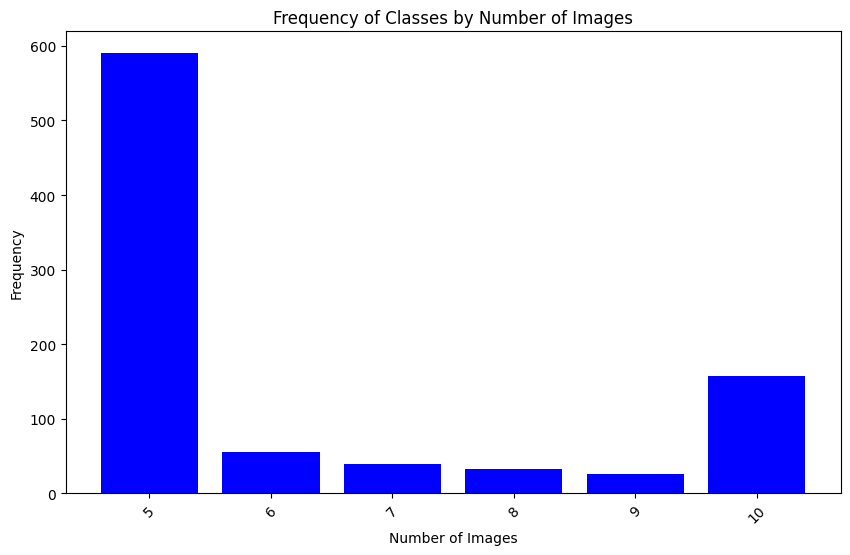

In [ ]:
# Bar chart to display number images per class

plt.figure(figsize=(10, 6))
plt.bar(augmented_frequency_df['Number of Images'], augmented_frequency_df['Frequency'], color='blue')

plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Frequency of Classes by Number of Images')

plt.xticks(rotation=45)

plt.show()

In [ ]:
# Compare before and after augmentation

# Add top level category
small_frequency_df.columns = pd.MultiIndex.from_product([['Before Augmentation'], small_frequency_df.columns])
augmented_frequency_df.columns = pd.MultiIndex.from_product([['After Augmentation'], augmented_frequency_df.columns])

# Merge
pd.merge(small_frequency_df, augmented_frequency_df, how='outer', left_on=[('Before Augmentation', 'Number of Images')],
                  right_on=[('After Augmentation', 'Number of Images')]).fillna(0)

Before Augmentation           After Augmentation          
     Number of Images Frequency   Number of Images Frequency
0                   3       291                0.0       0.0
1                   4       187                0.0       0.0
2                   5       112                5.0     590.0
3                   6        55                6.0      55.0
4                   7        39                7.0      39.0
5                   8        33                8.0      33.0
6                   9        26                9.0      26.0
7                  10       158               10.0     158.0

We have succsefully added images, and no class has below 5 or above 10 images, as can also be seen in the before and after augmentation.

## Final data preperations before training

In [ ]:
# Splitting to test and train. First image from each folder will be moved
# The first image will always be an original one, not augmented

parent_dir = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset'
test_dir = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/test'

split_train_test(parent_dir, test_dir)

In [ ]:
# Transform which included our crop_face method to pass each face in the desired size. We also normalize the data

transform = transforms.Compose([transforms.Lambda(lambda x: crop_face(x)) ,transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = datasets.ImageFolder(root='/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/smallset', transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
len(trainset)

4730

We are going to train our network with 4730 images and test 901 images in total. We chose a batch size of 8 because in the paper they used 128 for 4M images. The ratio is less than an image if we compare to our 5K dataset, so we chose a number which is not too high but still reflects how the original network was trained.

# **Training and Results**

In [ ]:
# Verify the network runs before we start
num_classes=901

model = DeepFace(num_classes)
model._init_weights_and_biases()
model.to(device)

x = torch.randn(3, 3, 152, 152)

out=model.forward(x)
print(out.size())

torch.Size([3, 901])


In [ ]:
# Parameters

model = DeepFace(num_classes) # define the model
model._init_weights_and_biases() # initialize weights and bais
model.to(device)

# Setting the loss function
loss_deep_face = nn.CrossEntropyLoss() # used in the paper

# Define learning_rate
learning_rate=0.000001 # used in the paper

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # paper used SGD

In [ ]:
# Train the model

num_epochs = 5 # There was no need to run more than five epochs as could be seen in the results section
losses = []
average_loss = []

if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0
    total_loss=0.0

    for i, data in enumerate(tqdm(trainloader), 0):
      optimizer.zero_grad()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      if torch.any(torch.isnan(inputs)) or torch.any(torch.isnan(outputs)):
        print("NaN detected in inputs or outputs")

      loss = loss_deep_face(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      total_loss += loss.item()

      if i % 100 == 99:  # print every 100 mini-batche
        # avg_loss = running_loss / 100
        # pbar.set_description(f'Epoch {epoch + 1} Loss: {avg_loss:.3f}')
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        average_loss.append(running_loss/100)
        running_loss = 0.0

    losses.append(total_loss/len(trainloader))

    print('Finished Training')

  0%|          | 0/592 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ddcd015d240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ddcd015d240>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ddcd015d240>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/loc

[1,   100] loss: 365.603


 34%|███▍      | 200/592 [05:31<09:46,  1.50s/it]

[1,   200] loss: 211.338


 51%|█████     | 300/592 [08:12<06:34,  1.35s/it]

[1,   300] loss: 171.591


 68%|██████▊   | 400/592 [11:42<05:55,  1.85s/it]

[1,   400] loss: 140.180


 84%|████████▍ | 500/592 [15:13<01:43,  1.13s/it]

[1,   500] loss: 108.617


100%|██████████| 592/592 [17:53<00:00,  1.81s/it]


Finished Training


 17%|█▋        | 100/592 [00:52<03:22,  2.43it/s]

[2,   100] loss: 55.800


 34%|███▍      | 200/592 [01:46<02:49,  2.31it/s]

[2,   200] loss: 30.943


 51%|█████     | 300/592 [02:37<02:51,  1.71it/s]

[2,   300] loss: 11.643


 68%|██████▊   | 400/592 [03:29<01:26,  2.21it/s]

[2,   400] loss: 6.961


 84%|████████▍ | 500/592 [04:21<00:38,  2.41it/s]

[2,   500] loss: 6.806


100%|██████████| 592/592 [05:08<00:00,  1.92it/s]


Finished Training


 17%|█▋        | 100/592 [00:52<03:20,  2.45it/s]

[3,   100] loss: 6.804


 34%|███▍      | 200/592 [01:45<02:50,  2.29it/s]

[3,   200] loss: 6.806


 51%|█████     | 300/592 [02:37<02:44,  1.78it/s]

[3,   300] loss: 6.804


 68%|██████▊   | 400/592 [03:28<01:23,  2.31it/s]

[3,   400] loss: 6.804


 84%|████████▍ | 500/592 [04:20<00:39,  2.35it/s]

[3,   500] loss: 6.804


100%|██████████| 592/592 [05:08<00:00,  1.92it/s]


Finished Training


 17%|█▋        | 100/592 [00:52<03:19,  2.47it/s]

[4,   100] loss: 6.804


 34%|███▍      | 200/592 [01:45<02:27,  2.66it/s]

[4,   200] loss: 6.804


 51%|█████     | 300/592 [02:38<02:19,  2.09it/s]

[4,   300] loss: 6.804


 68%|██████▊   | 400/592 [03:29<01:49,  1.76it/s]

[4,   400] loss: 6.804


 84%|████████▍ | 500/592 [04:21<00:37,  2.47it/s]

[4,   500] loss: 6.804


100%|██████████| 592/592 [05:09<00:00,  1.91it/s]


Finished Training


 17%|█▋        | 100/592 [00:51<03:13,  2.55it/s]

[5,   100] loss: 6.804


 34%|███▍      | 200/592 [01:44<02:53,  2.26it/s]

[5,   200] loss: 6.804


 51%|█████     | 300/592 [02:36<02:01,  2.41it/s]

[5,   300] loss: 6.804


 68%|██████▊   | 400/592 [03:28<01:52,  1.71it/s]

[5,   400] loss: 6.804


 84%|████████▍ | 500/592 [04:19<00:38,  2.40it/s]

[5,   500] loss: 6.804


100%|██████████| 592/592 [05:09<00:00,  1.92it/s]

Finished Training


In [ ]:
testset_path = '/content/drive/My Drive/DeepFaceDataExploration/lfw-deepfunneled/test'

model_accuracy(model, testset_path)

Test Accuracy: 0.11%


0.11098779134295228

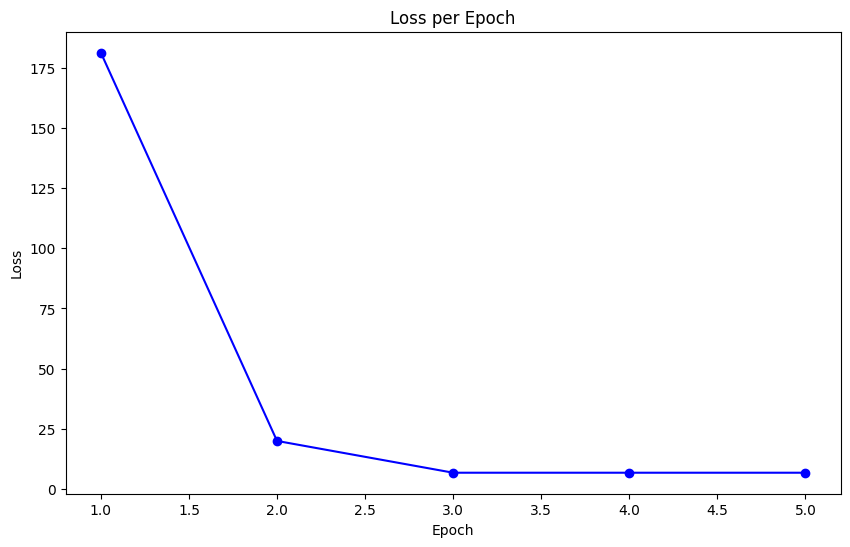

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, marker='o', linestyle='-', color='blue')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The network starts off nicely but gets stuck after ~3 epochs. The gradients vanish and there's no addtional learning at this stage. To try and resolve we've tested:


*   Different learning rates - higher resulted in exploding gradients
*   Random or no bias
*   Adam optimizer
*   Gradient clipping

We have not added all these tests to this notebook as non of them made any difference.

This was the stage we presented during the final lecture.



# **Imporovements**

## Dataset

From our intial testing we could not imporove results further. **Our conclusion was that the data size per class is not sufficient**. So the first modification is to increase sample size per class at the expense of number of classes as we cannot increase the total data size with our HW limitations.

In [ ]:
final_data_df = data_review('/content/drive/MyDrive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled')

We are going to take classes with 20-80 images and augment addtional images.

In [ ]:
source_dir = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled'
target_dir = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset'
copy_directory_if_images_exceed(source_dir, target_dir, 20, 80) # move from source to target all folders with 20-80 images

Copied directory: /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled/Alejandro_Toledo to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Alejandro_Toledo
Copied directory: /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled/Alvaro_Uribe to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Alvaro_Uribe
Copied directory: /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled/Amelie_Mauresmo to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Amelie_Mauresmo
Copied directory: /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled/Andre_Agassi to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Andre_Agassi
Copied directory: /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-deepfunneled/Angelina_Jolie to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Angelina_Jolie
Copied directory: /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/lfw-d

In [ ]:
final_data_df = data_review('/content/drive/MyDrive/DeepFaceData/lfw-deepfunneled/smallset')

In [ ]:
# number of classes
len(final_data_df.index)

57

In [ ]:
# number of images
final_data_df['Number of Images'].sum()

1883

In [ ]:
# Class with max number of images
final_data_df.sort_values(by='Number of Images', ascending=False).head(1)

,Class Name,Number of Images
5,Ariel_Sharon,77


In [ ]:
frequency_final_data_df = data_frequency(final_data_df)

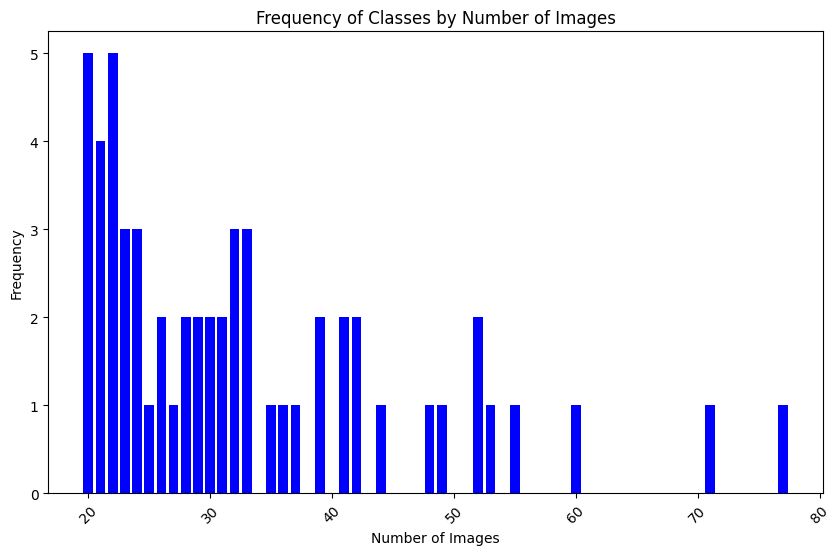

In [ ]:
# Bar chart to display number images per class

plt.figure(figsize=(10, 6))
plt.bar(frequency_final_data_df['Number of Images'], frequency_final_data_df['Frequency'], color='blue')

plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Frequency of Classes by Number of Images')

plt.xticks(rotation=45)

plt.show()

In [ ]:
# Splitting to test and train. First image from each folder will be moved. In this way, we won't have any augmented versions of the test image

parent_dir = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset'
test_dir = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/test'

split_train_test(parent_dir, test_dir)

In [ ]:
# Augment images to get 76 images in total. Max class had 77 images, we took one for test, so 76 is now the max size

# call augmenting method
dir = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset'

for root, dirs, files in os.walk(dir):
  # count number of images in the subfolder
  num_files = len([file for file in files if file.endswith(('jpg', 'png', 'jpeg'))])
  if num_files >= 76 or num_files == 0: # this will pass all folders besides the max class
    continue
  else:
    print(root)
    augment(76-num_files, root) # pass the directory + how many images we want to add in order to get a total of 76 images

/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Alejandro_Toledo
Initialised with 38 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Alejandro_Toledo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F1A56E7B80>: 100%|██████████| 38/38 [00:00<00:00, 50.64 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Alvaro_Uribe
Initialised with 34 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Alvaro_Uribe.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F1A3894070>: 100%|██████████| 42/42 [00:01<00:00, 37.72 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Amelie_Mauresmo
Initialised with 20 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Amelie_Mauresmo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F1A38AB910>: 100%|██████████| 56/56 [00:01<00:00, 33.42 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Andre_Agassi
Initialised with 35 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Andre_Agassi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B7B47C0>: 100%|██████████| 41/41 [00:01<00:00, 32.80 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Angelina_Jolie
Initialised with 19 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Angelina_Jolie.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B7B6BC0>: 100%|██████████| 57/57 [00:01<00:00, 43.21 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Arnold_Schwarzenegger
Initialised with 41 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Arnold_Schwarzenegger.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B639180>: 100%|██████████| 35/35 [00:00<00:00, 53.01 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Atal_Bihari_Vajpayee
Initialised with 23 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Atal_Bihari_Vajpayee.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F1A56E7970>: 100%|██████████| 53/53 [00:01<00:00, 50.35 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Bill_Clinton
Initialised with 28 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Bill_Clinton.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B63AA10>: 100%|██████████| 48/48 [00:00<00:00, 53.19 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Carlos_Menem
Initialised with 20 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Carlos_Menem.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F1A38AB0D0>: 100%|██████████| 56/56 [00:01<00:00, 40.87 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/David_Beckham
Initialised with 30 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/David_Beckham.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B63B970>: 100%|██████████| 46/46 [00:00<00:00, 49.00 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/George_Robertson
Initialised with 21 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/George_Robertson.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B63BD60>: 100%|██████████| 55/55 [00:01<00:00, 49.48 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Gloria_Macapagal_Arroyo
Initialised with 43 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Gloria_Macapagal_Arroyo.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6441C0>: 100%|██████████| 33/33 [00:00<00:00, 51.67 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Gray_Davis
Initialised with 25 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Gray_Davis.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B647C70>: 100%|██████████| 51/51 [00:01<00:00, 48.51 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Guillermo_Coria
Initialised with 29 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Guillermo_Coria.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B646080>: 100%|██████████| 47/47 [00:01<00:00, 32.61 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Hamid_Karzai
Initialised with 21 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Hamid_Karzai.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x79F18B647D30>: 100%|██████████| 55/55 [00:01<00:00, 30.16 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Hans_Blix
Initialised with 38 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Hans_Blix.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B644C70>: 100%|██████████| 38/38 [00:01<00:00, 26.93 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Hugo_Chavez
Initialised with 70 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Hugo_Chavez.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B664DF0>: 100%|██████████| 6/6 [00:00<00:00, 33.97 Samples/s]

/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Igor_Ivanov


Initialised with 19 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Igor_Ivanov.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B647CA0>: 100%|██████████| 57/57 [00:01<00:00, 51.30 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jack_Straw
Initialised with 27 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jack_Straw.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B664070>: 100%|██████████| 49/49 [00:00<00:00, 51.23 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jacques_Chirac
Initialised with 51 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jacques_Chirac.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B666260>: 100%|██████████| 25/25 [00:01<00:00, 17.25 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jean_Chretien
Initialised with 54 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jean_Chretien.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B667130>: 100%|██████████| 22/22 [00:00<00:00, 49.63 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jennifer_Aniston
Initialised with 20 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jennifer_Aniston.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6646D0>: 100%|██████████| 56/56 [00:01<00:00, 48.52 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jennifer_Capriati
Initialised with 41 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jennifer_Capriati.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B664FD0>: 100%|██████████| 35/35 [00:00<00:00, 47.18 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jennifer_Lopez
Initialised with 20 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jennifer_Lopez.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B665210>: 100%|██████████| 56/56 [00:01<00:00, 47.91 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jeremy_Greenstock
Initialised with 23 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jeremy_Greenstock.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B677040>: 100%|██████████| 53/53 [00:01<00:00, 45.06 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jiang_Zemin
Initialised with 19 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jiang_Zemin.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x79F18B677C10>: 100%|██████████| 57/57 [00:01<00:00, 32.23 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/John_Ashcroft
Initialised with 52 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/John_Ashcroft.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B675270>: 100%|██████████| 24/24 [00:00<00:00, 33.74 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/John_Negroponte
Initialised with 30 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/John_Negroponte.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B675000>: 100%|██████████| 46/46 [00:01<00:00, 30.01 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jose_Maria_Aznar
Initialised with 22 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Jose_Maria_Aznar.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B676650>: 100%|██████████| 54/54 [00:01<00:00, 46.56 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Juan_Carlos_Ferrero
Initialised with 27 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Juan_Carlos_Ferrero.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x79F18B7B51B0>: 100%|██████████| 49/49 [00:01<00:00, 47.43 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Junichiro_Koizumi
Initialised with 59 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Junichiro_Koizumi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B691750>: 100%|██████████| 17/17 [00:00<00:00, 57.58 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Kofi_Annan
Initialised with 31 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Kofi_Annan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B676080>: 100%|██████████| 45/45 [00:00<00:00, 48.70 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Laura_Bush
Initialised with 40 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Laura_Bush.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B690910>: 100%|██████████| 36/36 [00:00<00:00, 47.81 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Lindsay_Davenport
Initialised with 21 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Lindsay_Davenport.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B644B20>: 100%|██████████| 55/55 [00:01<00:00, 49.77 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Lleyton_Hewitt
Initialised with 40 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Lleyton_Hewitt.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x79F18B692890>: 100%|██████████| 36/36 [00:00<00:00, 46.38 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Luiz_Inacio_Lula_da_Silva
Initialised with 47 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Luiz_Inacio_Lula_da_Silva.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6A56F0>: 100%|██████████| 29/29 [00:00<00:00, 51.61 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Mahmoud_Abbas
Initialised with 28 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Mahmoud_Abbas.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B691A80>: 100%|██████████| 48/48 [00:00<00:00, 52.52 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Megawati_Sukarnoputri
Initialised with 32 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Megawati_Sukarnoputri.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B644B20>: 100%|██████████| 44/44 [00:00<00:00, 47.56 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Michael_Bloomberg
Initialised with 19 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Michael_Bloomberg.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6A7F70>: 100%|██████████| 57/57 [00:01<00:00, 29.87 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Naomi_Watts
Initialised with 21 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Naomi_Watts.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6A6FB0>: 100%|██████████| 55/55 [00:01<00:00, 31.27 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Nestor_Kirchner
Initialised with 36 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Nestor_Kirchner.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6A5630>: 100%|██████████| 40/40 [00:01<00:00, 36.58 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Paul_Bremer
Initialised with 19 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Paul_Bremer.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6A4D60>: 100%|██████████| 57/57 [00:01<00:00, 49.71 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Pete_Sampras
Initialised with 21 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Pete_Sampras.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6A77C0>: 100%|██████████| 55/55 [00:01<00:00, 47.52 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Recep_Tayyip_Erdogan
Initialised with 29 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Recep_Tayyip_Erdogan.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6C8A60>: 100%|██████████| 47/47 [00:00<00:00, 47.17 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Ricardo_Lagos
Initialised with 26 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Ricardo_Lagos.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6CBE50>: 100%|██████████| 50/50 [00:01<00:00, 46.46 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Roh_Moo-hyun
Initialised with 31 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Roh_Moo-hyun.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6C9450>: 100%|██████████| 45/45 [00:00<00:00, 47.48 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Rudolph_Giuliani
Initialised with 25 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Rudolph_Giuliani.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B644E80>: 100%|██████████| 51/51 [00:01<00:00, 48.80 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Saddam_Hussein
Initialised with 22 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Saddam_Hussein.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6CB910>: 100%|██████████| 54/54 [00:01<00:00, 47.13 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Serena_Williams
Initialised with 51 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Serena_Williams.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6B9600>: 100%|██████████| 25/25 [00:00<00:00, 49.13 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Silvio_Berlusconi
Initialised with 32 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Silvio_Berlusconi.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6BAEC0>: 100%|██████████| 44/44 [00:01<00:00, 40.79 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Tiger_Woods
Initialised with 22 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Tiger_Woods.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6BBBB0>: 100%|██████████| 54/54 [00:01<00:00, 30.50 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Tom_Daschle
Initialised with 24 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Tom_Daschle.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6BA230>: 100%|██████████| 52/52 [00:01<00:00, 34.30 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Tom_Ridge
Initialised with 32 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Tom_Ridge.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6BB9A0>: 100%|██████████| 44/44 [00:01<00:00, 36.66 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Vicente_Fox
Initialised with 31 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Vicente_Fox.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6B9120>: 100%|██████████| 45/45 [00:00<00:00, 46.10 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Vladimir_Putin
Initialised with 48 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Vladimir_Putin.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6B9A20>: 100%|██████████| 28/28 [00:00<00:00, 50.75 Samples/s]


/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Winona_Ryder
Initialised with 23 image(s) found.
Output directory set to /content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset/Winona_Ryder.

Processing <PIL.Image.Image image mode=RGB size=250x250 at 0x79F18B6DEE00>: 100%|██████████| 53/53 [00:01<00:00, 43.46 Samples/s]


In [ ]:
augmented_final_df = data_review('/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/smallset')

In [ ]:
# number of classes
len(augmented_final_df.index)

57

In [ ]:
# number of images
augmented_final_df['Number of Images'].sum()

4332

To conclude the first modification, we've adjusted the data and recieved a similar training data size with lower number of classes. We have 76 images per class where we augmented images in order to balance the dataset.

Total number of classes is 57 and 4332 images in total for training.

## Training mechanism

Following the classrom presentation and excersice #2, we've decided to change the training mechanism in two directions:

1.   Split into train and validation data
2.   Add additional augmentation to the dataloader

Since we don't have a lot of data we took only 10% for validation. This would help us understand further what is happening in the network and also allow us to compare with other network modifications. We also added a random seed to verify all data splits will be constant accross tests.

In [ ]:
# Adding additional augmentation, this will add variations to images we have not augmented. We've kept it for flipping images and color adjustments only

transform = transforms.Compose([transforms.Lambda(lambda x: crop_face(x)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = datasets.ImageFolder(root='smallset', transform=transform)

In [ ]:
len(trainset)

4332

In [ ]:
# define training size
train_size = int(0.9 * len(trainset))
# define validation size
validation_size = len(trainset) - train_size
# split the trainset
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=8, num_workers=2)
validationloader = DataLoader(validation_dataset, batch_size=8, num_workers=2)

In [ ]:
len(trainloader)

488

In [ ]:
len(validationloader)

55

## Second training of DeepFace

In [ ]:
# Parameters
num_classes = 57

model = DeepFace(num_classes)
model._init_weights_and_biases()
model.to(device)

# Setting the loss function
loss_deep_face = nn.CrossEntropyLoss()

# Define learning_rate
learning_rate=0.000001

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Training and comparing between test and validation loss

num_epochs = 15
training_losses = []
validation_losses = []

if __name__ == '__main__':
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_deep_face(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_deep_face(outputs, labels)
                running_loss += loss.item()

        validation_loss = running_loss / len(validationloader)
        validation_losses.append(validation_loss)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    print('Finished Training')

Epoch 1/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 1, Train Loss: 138.9330, Validation Loss: 17.7879


Epoch 2/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 2, Train Loss: 68.7567, Validation Loss: 13.6329


Epoch 3/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 3, Train Loss: 37.6530, Validation Loss: 8.5485


Epoch 4/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 4, Train Loss: 12.0214, Validation Loss: 4.1995


Epoch 5/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 5, Train Loss: 4.1272, Validation Loss: 4.0457


Epoch 6/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>Exception ignored in: 
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLo

Epoch 6, Train Loss: 4.0446, Validation Loss: 4.0428


Epoch 7/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

Epoch 7, Train Loss: 4.0455, Validation Loss: 4.0433


Epoch 8/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

Epoch 8, Train Loss: 4.0438, Validation Loss: 4.0431


Epoch 9/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():
      File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive


Epoch 9, Train Loss: 4.0439, Validation Loss: 4.0430


Exception ignored in: 

Epoch 10/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>Traceback (most recent call last):

  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f144675d040>  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

Exception ignored in: 
    Traceback (most recent ca

Epoch 10, Train Loss: 4.0442, Validation Loss: 4.0431


Epoch 11/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 11, Train Loss: 4.0442, Validation Loss: 4.0431


Epoch 12/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 12, Train Loss: 4.0437, Validation Loss: 4.0431


Epoch 13/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 13, Train Loss: 4.0431, Validation Loss: 4.0426


Epoch 14/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 14, Train Loss: 4.0441, Validation Loss: 4.0432


Epoch 15/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 15, Train Loss: 4.0439, Validation Loss: 4.0431
Finished Training


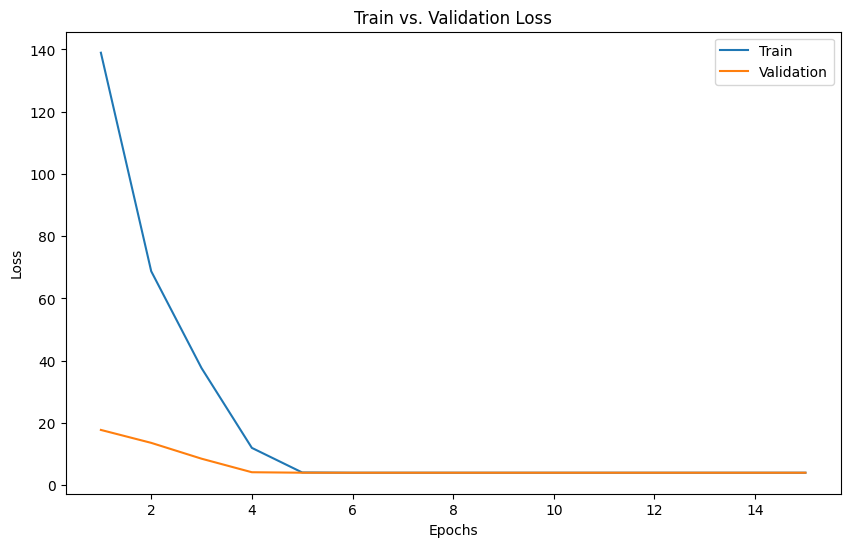

In [ ]:
# Plotting train vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Train')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation')

plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
torch.save(model, 'deepfacemodel.pth')

# Save the weights
torch.save(model.state_dict(), 'deepface_weights.pth')

In [ ]:
testset_path = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/test'

correct_labels = model_accuracy(model, testset_path)

Test Accuracy: 1.75%


In [ ]:
# number of correctly labeled images
len(correct_labels)

1

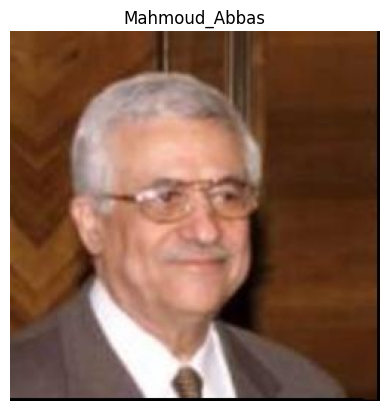

In [ ]:
# the correctly labeled class

img_path = correct_labels[0]

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

dir_name = os.path.basename(os.path.dirname(img_path))
plt.title(f"{dir_name}")

plt.show()

Since the results are still low, we did one last try on removing the validation set in order to increase the training data.

In [ ]:
# trainset containing all of the images without train and validation

trainset = datasets.ImageFolder(root='/content/drive/MyDrive/DeepFaceData/lfw-deepfunneled/smallset', transform=transform)
trainloader = DataLoader(trainset, batch_size=8, num_workers=2)

In [ ]:
len(trainloader)

542

In [ ]:
# train the model

num_epochs = 15
losses = []
average_loss = []

if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0
    total_loss=0.0

    for i, data in enumerate(tqdm(trainloader), 0):
      optimizer.zero_grad()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      if torch.any(torch.isnan(inputs)) or torch.any(torch.isnan(outputs)):
        print("NaN detected in inputs or outputs")

      loss = loss_deep_face(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      total_loss += loss.item()

      if i % 100 == 99:  # print every 100 mini-batche
        # avg_loss = running_loss / 100
        # pbar.set_description(f'Epoch {epoch + 1} Loss: {avg_loss:.3f}')
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        average_loss.append(running_loss/100)
        running_loss = 0.0

    losses.append(total_loss/len(trainloader))

    print('Finished Training')

  0%|          | 0/542 [00:00<?, ?it/s]

[1,   100] loss: 238.620
[1,   200] loss: 57.301
[1,   300] loss: 63.276
[1,   400] loss: 59.933
[1,   500] loss: 56.217
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[2,   100] loss: 50.122
[2,   200] loss: 46.835
[2,   300] loss: 45.019


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

[2,   400] loss: 42.904
[2,   500] loss: 42.869
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[3,   100] loss: 42.011
[3,   200] loss: 41.178


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

[3,   300] loss: 38.238
[3,   400] loss: 34.824
[3,   500] loss: 34.312
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[4,   100] loss: 34.227


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

[4,   200] loss: 31.753
[4,   300] loss: 31.167
[4,   400] loss: 29.918
[4,   500] loss: 27.894
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 1

[5,   100] loss: 26.815
[5,   200] loss: 24.978
[5,   300] loss: 24.077
[5,   400] loss: 22.727
[5,   500] loss: 22.119
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[6,   100] loss: 21.058
[6,   200] loss: 20.178
[6,   300] loss: 18.031
[6,   400] loss: 18.269
[6,   500] loss: 15.570
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[7,   100] loss: 14.134
[7,   200] loss: 12.868
[7,   300] loss: 13.201
[7,   400] loss: 11.926
[7,   500] loss: 10.734
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[8,   100] loss: 10.030
[8,   200] loss: 9.627
[8,   300] loss: 8.726
[8,   400] loss: 8.063
[8,   500] loss: 7.396
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[9,   100] loss: 6.721
[9,   200] loss: 6.124
[9,   300] loss: 5.424
[9,   400] loss: 5.367
[9,   500] loss: 4.469
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[10,   100] loss: 3.829
[10,   200] loss: 3.572
[10,   300] loss: 3.284
[10,   400] loss: 2.820
[10,   500] loss: 2.705
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[11,   100] loss: 3.334
[11,   200] loss: 4.117
[11,   300] loss: 3.887
[11,   400] loss: 3.989
[11,   500] loss: 4.049
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[12,   100] loss: 3.900
[12,   200] loss: 3.977
[12,   300] loss: 4.053
[12,   400] loss: 4.044
[12,   500] loss: 4.043
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[13,   100] loss: 4.043
[13,   200] loss: 4.043
[13,   300] loss: 4.043
[13,   400] loss: 4.043
[13,   500] loss: 4.043
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[14,   100] loss: 4.043
[14,   200] loss: 4.043
[14,   300] loss: 4.043


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

[14,   400] loss: 4.043
[14,   500] loss: 4.043
Finished Training


  0%|          | 0/542 [00:00<?, ?it/s]

[15,   100] loss: 4.044
[15,   200] loss: 4.045


Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88663233a0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

[15,   300] loss: 4.038
[15,   400] loss: 3.933
[15,   500] loss: 4.043
Finished Training


In [ ]:
# test accuracy
testset_path = '/content/drive/My Drive/DeepFaceData/lfw-deepfunneled/test'

correct_labels = model_accuracy(model, testset_path)

Test Accuracy: 1.75%


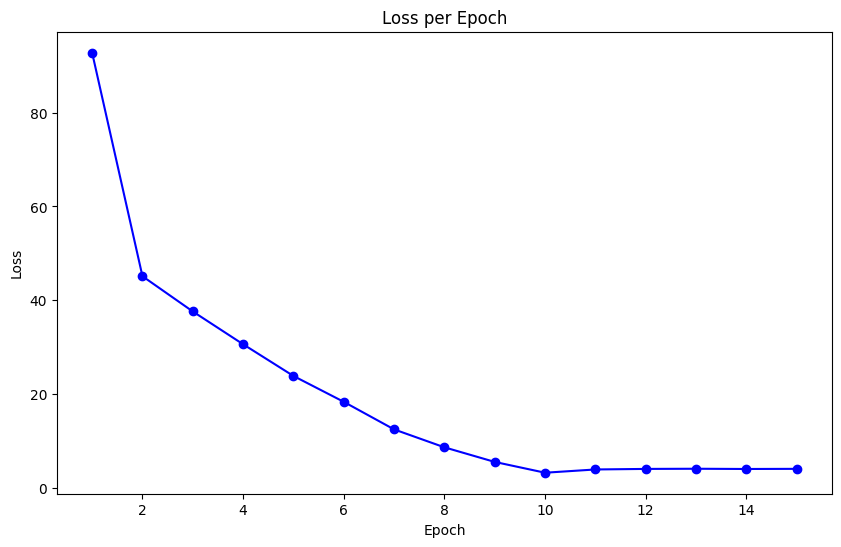

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, marker='o', linestyle='-', color='blue')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# number of correctly labeled images
len(correct_labels)

1

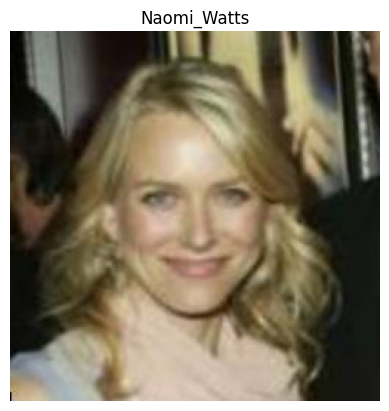

In [ ]:
# the correctly labeled class

img_path = correct_labels[0]

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

dir_name = os.path.basename(os.path.dirname(img_path))
plt.title(f"{dir_name}")

plt.show()

After drilling down to what's happening in the network, we see that the network still comes to a stop in learning and predicts always the same class. So in the last case every prediction is Naomi Watts and there's one time that's actaully true.

In order not to expand this notebook too much, we'll mention that the network was tested on only six classes with 76 images on each, and the results are the same. One class is being predicted at all times. The predicted class is random.

We have not found any improvement by reducing class size and currently conclude **that the amount of data per class for this type of architecture is too small and different architectures should be considered**. The modifications could not be centered around hyper parameters or optimizers.

## Arcithecture improvements

### VGG type

The first modification is to replace the locally connected layer. Around the same time Facebook published this paper, VGG16 was also introduced with a concept of a deeper convolution network. Our suggestion is to increase depth at the expence of removing the locally connected layers.

We took the VGG base network and adjusted it to our dimensions. VGG starts at 224x224 input size, but our netwrok is 152x152. Dimensions were calculated accordingly. We've decided to keep the number of layers even though the final layer's dimension is small (VGG final convolution layer is 7x7, ours is 4x4).

For training, we've also decided to used adam optimizer instead of SGD as it is more common for image classification.



In [ ]:
class DeepFaceVGG(nn.Module):
  def __init__(self, num_classes):
    super(DeepFaceVGG, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU())
    self.layer2 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU())
    self.layer4 = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer5 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU())
    self.layer6 = nn.Sequential(
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU())
    self.layer7 = nn.Sequential(
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer8 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU())
    self.layer9 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU())
    self.layer10 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer11 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU())
    self.layer12 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU())
    self.layer13 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.flat = nn.Flatten()
    self.fc = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(8192, 4096),
      nn.ReLU())
    self.fc1 = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU())
    self.fc2 = nn.Sequential(
      nn.Linear(4096, num_classes))

  def forward(self, x):
      # Input: (3, 152, 152)
      out = self.layer1(x)  # Output: (64, 152, 152)
      out = self.layer2(out)  # Output: (64, 76, 76)
      out = self.layer3(out)  # Output: (128, 76, 76)
      out = self.layer4(out)  # Output: (128, 38, 38)
      out = self.layer5(out)  # Output: (256, 38, 38)
      out = self.layer6(out)  # Output: (256, 38, 38)
      out = self.layer7(out)  # Output: (256, 19, 19)
      out = self.layer8(out)  # Output: (512, 19, 19)
      out = self.layer9(out)  # Output: (512, 19, 19)
      out = self.layer10(out)  # Output: (512, 9, 9)
      out = self.layer11(out)  # Output: (512, 9, 9)
      out = self.layer12(out)  # Output: (512, 9, 9)
      out = self.layer13(out)  # Output: (512, 4, 4)
      out = self.flat(out)  # Output: (8192)
      out = self.fc(out)  # Output: (4096)
      out = self.fc1(out)  # Output: (4096)
      out = self.fc2(out)  # Output: (num_classes)
      return out


In [ ]:
# Parameters
num_classes = 57

model = DeepFaceVGG(num_classes)
model.to(device)

# Setting the loss function
loss_deep_face = nn.CrossEntropyLoss()

# Define learning_rate
learning_rate=0.0001

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training and comparing between test and validation loss

num_epochs = 15
training_losses = []
validation_losses = []

if __name__ == '__main__':
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_deep_face(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_deep_face(outputs, labels)
                running_loss += loss.item()

        validation_loss = running_loss / len(validationloader)
        validation_losses.append(validation_loss)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    print('Finished Training')

Epoch 1/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 1, Train Loss: 4.0360, Validation Loss: 3.9370


Epoch 2/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 2, Train Loss: 3.7642, Validation Loss: 3.3976


Epoch 3/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 3, Train Loss: 3.2272, Validation Loss: 2.8146


Epoch 4/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 4, Train Loss: 2.5695, Validation Loss: 2.1198


Epoch 5/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 5, Train Loss: 1.8364, Validation Loss: 1.5105


Epoch 6/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers


Epoch 6, Train Loss: 1.2098, Validation Loss: 1.0776


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>
Traceback (most recent call last):


Epoch 7/15:   0%|          | 0/488 [00:00<?, ?batch/s]

  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()

Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-pa

Epoch 7, Train Loss: 0.7282, Validation Loss: 0.8177


Epoch 8/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f333c37c1f0>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers


Epoch 8, Train Loss: 0.4209, Validation Loss: 0.6612


Epoch 9/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 9, Train Loss: 0.2280, Validation Loss: 0.6120


Epoch 10/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 10, Train Loss: 0.1415, Validation Loss: 0.6224


Epoch 11/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 12, Train Loss: 0.0709, Validation Loss: 0.5655


Epoch 13/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 13, Train Loss: 0.0634, Validation Loss: 0.5257


Epoch 14/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 14, Train Loss: 0.0596, Validation Loss: 0.6669


Epoch 15/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 15, Train Loss: 0.0571, Validation Loss: 0.4646
Finished Training


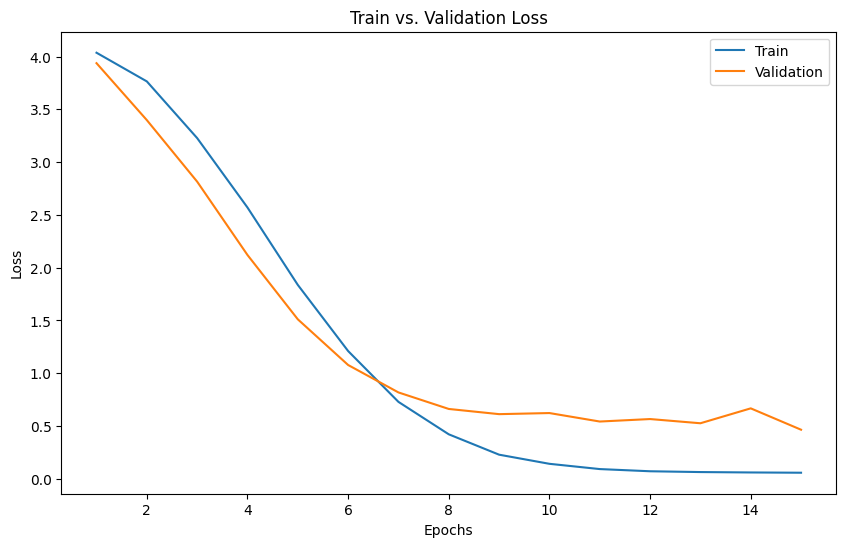

In [ ]:
# Plotting train vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Train')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation')

plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
testset_path = 'test'

correct_labels = model_accuracy(model, testset_path)

Test Accuracy: 71.93%


In [ ]:
len(correct_labels)

41

In [ ]:
correct_labels

['test/Alejandro_Toledo/Alejandro_Toledo_0001.jpg',
 'test/Alvaro_Uribe/Alvaro_Uribe_0001.jpg',
 'test/Andre_Agassi/Andre_Agassi_0001.jpg',
 'test/Ariel_Sharon/Ariel_Sharon_0001.jpg',
 'test/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg',
 'test/Bill_Clinton/Bill_Clinton_0001.jpg',
 'test/Carlos_Menem/Carlos_Menem_0001.jpg',
 'test/David_Beckham/David_Beckham_0001.jpg',
 'test/George_Robertson/George_Robertson_0001.jpg',
 'test/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0001.jpg',
 'test/Hans_Blix/Hans_Blix_0001.jpg',
 'test/Hugo_Chavez/Hugo_Chavez_0001.jpg',
 'test/Jack_Straw/Jack_Straw_0001.jpg',
 'test/Jacques_Chirac/Jacques_Chirac_0001.jpg',
 'test/Jennifer_Capriati/Jennifer_Capriati_0001.jpg',
 'test/Jeremy_Greenstock/Jeremy_Greenstock_0001.jpg',
 'test/Jiang_Zemin/Jiang_Zemin_0001.jpg',
 'test/John_Ashcroft/John_Ashcroft_0001.jpg',
 'test/John_Negroponte/John_Negroponte_0001.jpg',
 'test/Jose_Maria_Aznar/Jose_Maria_Aznar_0001.jpg',
 'test/Juan_Carlos_Ferrero/Juan_Carl

There is a significant change when deepening the network. Accuracy increased dramatically. We probalby could have run just 12 epochs for this scenario.

### Patches

Following class presentations, we came about the paper on "patches are all you need?" [DOI](https://doi.org/10.48550/arXiv.2201.09792). We've found the idea similar to DeepFace, as patches or sections of the image are being passes and processed seperately and each area is being reviewed and weighted. Since it's a more current and advanced netwrok we thought that it might be better suited for classification with smaller data size.

The network is pre-defined at pytorch libraries, and full implementation in the paper iteslf, but we've found an implementaiton online which was better suited [link](https://mrinath.medium.com/understanding-convmixer-with-a-simple-pytorch-implementation-c889f819a0b5)

In [ ]:
# Defining the network

class ConvMixer(nn.Module):
  def __init__(self,no_of_op_channels , depth , kernal , patch_size ,output ):
    super().__init__()
    self.o = no_of_op_channels
    self.d = depth
    self.k = kernal
    self.p = patch_size
    self.n = output
    self.bn = nn.BatchNorm2d(self.o)
    self.cnn1 = nn.Conv2d(3 , self.o , (self.p , self.p) , stride=self.p)
    self.bn1 = nn.BatchNorm2d(self.o)
    self.cnn2 = nn.Conv2d(self.o , self.o , (self.k , self.k) , groups=self.o , padding="same")
    self.bn2 = nn.BatchNorm2d(self.o)
    self.cnn3 = nn.Conv2d(self.o , self.o , (1,1))
    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(self.o , self.n)

  def forward(self , x):
    x = self.bn(F.gelu(self.cnn1(x)))
    for i in range(self.d):
      x = self.bn1(F.gelu(self.cnn2(x)))+ x #residual step and depthwise convolution
      x = self.bn2(F.gelu(self.cnn3(x))) #pointwise convolution
    x = self.pool(x)
    x = x.view(x.shape[0],-1)
    x = self.fc(x)
    return x

In [ ]:
# Parameters
num_classes = 57

model = ConvMixer(no_of_op_channels=64, depth=4, kernal=7, patch_size=9, output=num_classes)
model.to(device)

# Setting the loss function
loss_deep_face = nn.CrossEntropyLoss()

# Define learning_rate
learning_rate=0.001

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# We preffered to keep the image normalized at N(0,1) so we've removed the the normalization command from previous trainings

transform = transforms.Compose([transforms.Lambda(lambda x: crop_face(x)), transforms.ToTensor()])

In [ ]:
trainset = datasets.ImageFolder(root='smallset', transform=transform)

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=8, num_workers=2)
validationloader = DataLoader(validation_dataset, batch_size=8, num_workers=2)

In [ ]:
# Training and comparing between test and validation loss

num_epochs = 15
training_losses = []
validation_losses = []

if __name__ == '__main__':
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_deep_face(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_deep_face(outputs, labels)
                running_loss += loss.item()

        validation_loss = running_loss / len(validationloader)
        validation_losses.append(validation_loss)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    print('Finished Training')

Epoch 1/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 1, Train Loss: 3.8097, Validation Loss: 3.7493


Epoch 2/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 2, Train Loss: 3.3982, Validation Loss: 3.6377


Epoch 3/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 3, Train Loss: 3.1146, Validation Loss: 3.6475


Epoch 4/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 4, Train Loss: 2.8404, Validation Loss: 3.5585


Epoch 5/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 5, Train Loss: 2.5563, Validation Loss: 3.6212


Epoch 6/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 6, Train Loss: 2.3029, Validation Loss: 3.9019


Epoch 7/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 7, Train Loss: 2.0846, Validation Loss: 4.1213


Epoch 8/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 8, Train Loss: 1.8936, Validation Loss: 4.3306


Epoch 9/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 9, Train Loss: 1.7258, Validation Loss: 4.7495


Epoch 10/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 10, Train Loss: 1.5771, Validation Loss: 5.1302


Epoch 11/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d4a057160>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d4a057160>
    Traceback (most recent call last):
if w.is_alive():  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-pac

Epoch 11, Train Loss: 1.4480, Validation Loss: 5.5095


Epoch 12/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 12, Train Loss: 1.3320, Validation Loss: 5.8705


Epoch 13/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 13, Train Loss: 1.2271, Validation Loss: 6.2528


Epoch 14/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 14, Train Loss: 1.1330, Validation Loss: 6.5202


Epoch 15/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 15, Train Loss: 1.0491, Validation Loss: 6.6257
Finished Training


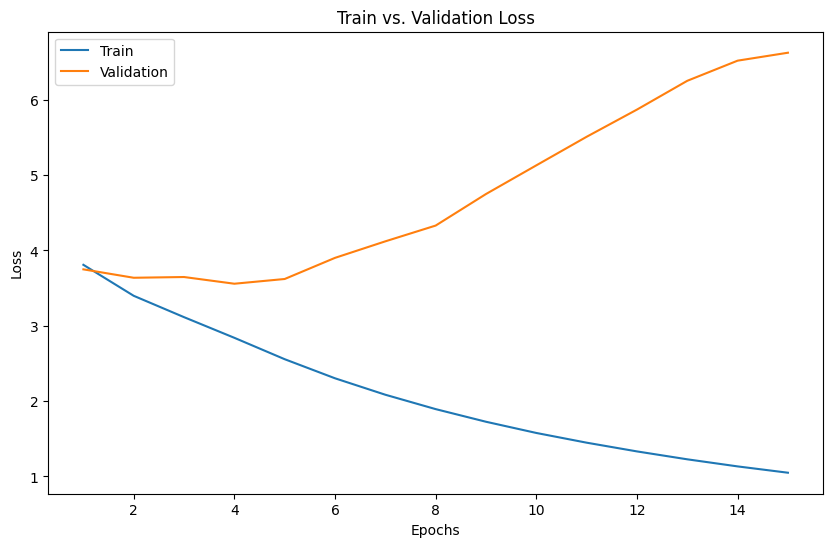

In [ ]:
# Plotting train vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Train')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation')

plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
testset_path = 'test'

correct_labels = model_accuracy(model, testset_path)

Test Accuracy: 3.51%


In [ ]:
len(correct_labels)

2

In [ ]:
correct_labels

['test/Bill_Clinton/Bill_Clinton_0001.jpg',
 'test/Laura_Bush/Laura_Bush_0001.jpg']

This network was able to be slightly more accurate compared to DeepFace and it wasn't strict to just one class. It does seem there is addtional learning to be done so we've increased learning rate and trained again.

In [ ]:
# Parameters
num_classes = 57

model = ConvMixer(no_of_op_channels=64, depth=4, kernal=7, patch_size=9, output=num_classes)
model.to(device)

# Setting the loss function
loss_deep_face = nn.CrossEntropyLoss()

# Define learning_rate
learning_rate=0.01

# Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training and comparing between test and validation loss

num_epochs = 15
training_losses = []
validation_losses = []

if __name__ == '__main__':
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_deep_face(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_deep_face(outputs, labels)
                running_loss += loss.item()

        validation_loss = running_loss / len(validationloader)
        validation_losses.append(validation_loss)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    print('Finished Training')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d4a057160>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d4a057160>
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/studio-lab-

Epoch 1/15:   0%|          | 0/488 [00:00<?, ?batch/s]

self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1, Train Loss: 3.6241, Validation Loss: 4.1268


Epoch 2/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 2, Train Loss: 2.9176, Validation Loss: 5.8211


Epoch 3/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 3, Train Loss: 2.2790, Validation Loss: 7.2493


Epoch 4/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 4, Train Loss: 1.7885, Validation Loss: 5.6328


Epoch 5/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 5, Train Loss: 1.5026, Validation Loss: 9.2675


Epoch 6/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 6, Train Loss: 1.2176, Validation Loss: 10.0817


Epoch 7/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 7, Train Loss: 1.0359, Validation Loss: 10.0983


Epoch 8/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 8, Train Loss: 0.8618, Validation Loss: 11.6284


Epoch 9/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 9, Train Loss: 0.7577, Validation Loss: 11.1154


Epoch 10/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 12, Train Loss: 0.4972, Validation Loss: 14.2737


Epoch 13/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d4a057160>
Traceback (most recent call last):
Exception ignored in:   File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d4a057160>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
      File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers


Epoch 13, Train Loss: 0.4856, Validation Loss: 13.2359


Epoch 14/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 14, Train Loss: 0.4539, Validation Loss: 13.6550


Epoch 15/15:   0%|          | 0/488 [00:00<?, ?batch/s]

Epoch 15, Train Loss: 0.3905, Validation Loss: 13.3189
Finished Training


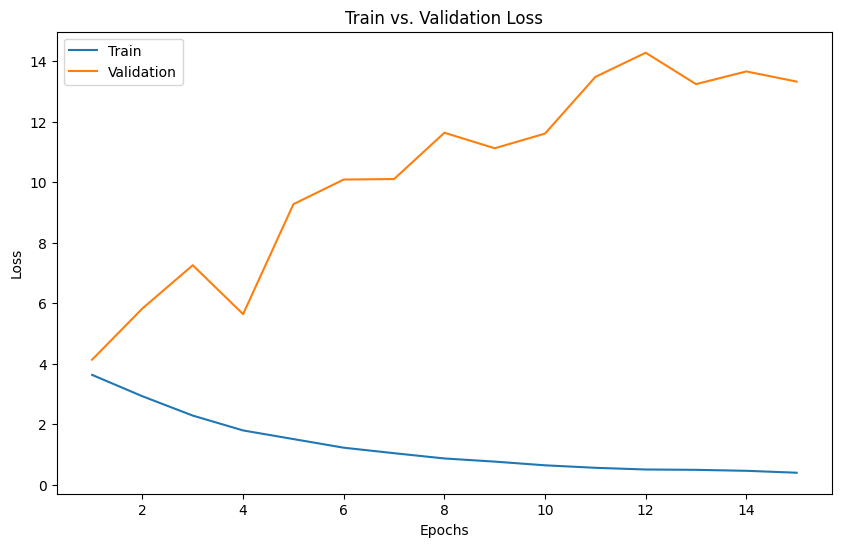

In [ ]:
# Plotting train vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, label='Train')
plt.plot(range(1, num_epochs+1), validation_losses, label='Validation')

plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
testset_path = 'test'

correct_labels = model_accuracy(model, testset_path)

Test Accuracy: 5.26%


In [ ]:
len(correct_labels)

3

In [ ]:
correct_labels

['test/Jennifer_Aniston/Jennifer_Aniston_0001.jpg',
 'test/Jeremy_Greenstock/Jeremy_Greenstock_0001.jpg',
 'test/Tom_Daschle/Tom_Daschle_0001.jpg']

Modifing the learning rate seems to overfit the model more. The increase in accuracy is not significant.

# **Summary**

## Results and conclusions

Throughout the project, we explored various options to understand how neural networks can be utilized for facial recognition, based on the research we selected. However, due to significant differences in the quantity of images in the data, stemming from the original study's use of non-public data, we had to rely on alternative data sources. Consequently, we were unable to replicate their results using their architecture, achieving only 0.11% accuracy compared to the original 97%. Even after augmenting the data by slightly increasing the number of photos for each individual, we still couldn't match their results, reaching only 1.75% accuracy.

These efforts also encompassed runs with both training and validation sets, but they yielded no improvement in the results. This prompted us to explore modifying their architecture. Initially, we adapted the network to resemble a VGG network by sequentially adding convolutional layers and interspersing pooling layers between them. This adjustment resulted in significantly improved performance, achieving an accuracy of 71.93% with 41 individuals correctly identified.

Subsequently, we experimented with a Patches-based architecture, which resulted in a notable decrease in accuracy to 3.51% compared to our previous attempt. However, we observed potential for improvement and subsequently increased the learning rate, albeit resulting in overfitting with only marginal performance gains. Even with the observed limitation, we believe that with a larger dataset there is a good potential for using Mixer layers and improve the network.

In conclusion, it appears that the network outlined in the article may not be suitable for small datasets. In fact, the authors themselves acknowledged the innovation of their approach on a large dataset. It seems that for smaller datasets, networks with numerous layers, such as VGG, may be more appropriate, although they still fall short of the original network's performance on its specific dataset.

Regarding the challenges encountered, two main issues arose. Firstly, the network incorporates locally connected layers, a concept not covered in our coursework. To comprehend their functionality and implementation, we relied on internet resources for guidance.

Secondly, we struggled when encountering accuracy results below 1 percent. Addressing this issue proved time-consuming and remains partially unresolved due to limited access to data similar to that used in the referenced article.

Lessons learned:

1.   Data is key. Deep learning requires a lot of it and it's not something that could be waived. It is more important than any hyper parameter we choose.
2.   Different networks are always worth considering. The paper is from 2014, and the field changed quite a bit. It's always worth considering new architectures for similar tasks and see if results and performance could be improved.
3.   New methods for data manupulation and new layers. We've had the opportunity to expand our knowledge in face detection, different convolution layers, augmentation and other on-hands coding techniques.
4.   Dimentionality - always something that needs monitoring. Many times we didn't account for it when implementing changes in our network.

## Discussion and future improvements

The gap between 72% accuracy and 97% is significant, and we are certain that with a proper database we could have replicated the paper's results. So although VGG was a better fit for this scenario, we are not, and can not state it's a superior solution in general.

Considering future improvements:

Different arcitectures - ResNet might be a good fit due to its skip connections which might help with vanishing gradients. This solution might be suitible to implement.

Combination between VGG and locally connected layers. The ability to apply different weights to segments of the image could still be benefitial, but if those layers will be added on a lower dimensionality stage, e.g. instaed of layer 10, it might give the network some boost and would not increase the number of parameters by a whole lot.

Due to the small dataset, methods such as zero shot learning e.g. the paper "Zero-shot face recognition" [DOI](https://doi.org/10.1016/j.eswa.2022.118635) should be explored. The use of attention to center on the most important attributes, which also shares some similarity with the idea of locally connected, can help resolve cases when we are short on data.

# Assistive Methods

In [ ]:
# Path were the data from kaggle was downloaded - will vary accross devices
dataset_path = '/content/drive/My Drive/archive.zip'

In [ ]:
# unzip the dataset for exploration
import zipfile
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/DeepFaceDataExploration')  # Extract to a specific directory

In [ ]:
# unzip the dataset for the final dataset
import zipfile
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/DeepFaceData')  # Extract to a specific directory

In [ ]:
# Method to iterate over the entire dataset and prepare a dataframe for data visualization
# Input - directory (String)
# Output - data_df

def data_review(directory):
  # Initialize a list to store the results
  data = []

  # Supported image extensions
  image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.tiff', '.bmp', '.svg']

  # Iterate over each item in the directory
  for folder_name in os.listdir(directory):
      folder_path = os.path.join(directory, folder_name)

      # Check if the current item is a directory
      if os.path.isdir(folder_path):
          image_count = 0

          # Iterate over each file in the folder
          for file in os.listdir(folder_path):
              if any(file.lower().endswith(ext) for ext in image_extensions):
                  image_count += 1

          # Append the folder name and the image count to the data list
          data.append([folder_name, image_count])

  # Create a DataFrame from the data list
  data_df = pd.DataFrame(data, columns=['Class Name', 'Number of Images'])

  return data_df

In [ ]:
# Method to calculate how many classes and how many images in that class
# Input - data df
# Output - frequency_df

def data_frequency(data_df):
  # Group by 'Number of Images' and count the occurrences, keep it as Series for now
  image_count_frequency_series = data_df.groupby('Number of Images').size()

  # Convert the Series into a DataFrame
  frequency_df = pd.DataFrame(image_count_frequency_series).reset_index()

  # Rename columns
  frequency_df.columns = ['Number of Images', 'Frequency']

  return frequency_df

In [ ]:
# method to adjust data per class since some classes e.g. Gorge W Bush have extreme size of images compared to others that have only one
# this method sets a limit of 10 images per class and will reduce the entire dataset from ~13000 images to ~10500

def adjust_image_data(dir):
    for root, dirs, files in os.walk(dir):
      if len(files) > 10:
        for i in range(10, len(files)):
          path = os.path.join(root, files[i])
          os.remove(path)

In [ ]:
# Method to copy classes where the range of image numbers is as requested

def copy_directory_if_images_exceed(source_dir, target_dir, min_image_count, max_image_count, image_extensions=['.jpg', '.png', '.jpeg']):
  # Ensure target directory exists
  if not os.path.exists(target_dir):
    os.makedirs(target_dir)

  # Walk through the source directory
  for root, dirs, files in os.walk(source_dir, topdown=False):
    image_count = 0

    # Count image files in the current directory
    for file in files:
      if any(file.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

    # If number of images found is between the min/max range, move the entire directory
    if (image_count >= min_image_count) & (image_count <= max_image_count):
      # Ensure the target path is unique to avoid overwriting
      relative_path = os.path.relpath(root, start=source_dir)
      target_path = os.path.join(target_dir, relative_path)
      if not os.path.exists(target_path):
        shutil.copytree(root, target_path)
        print(f"Copied directory: {root} to {target_path}")
      else:
        print(f"Target directory {target_path} already exists, cannot copy {root}.")

In [ ]:
# Method to augment random images
# Input - number of images to augment, path to the directory
# output - images are saved directly

def augment(size, path):
  # Define augmentation pipeline
  pipeline = Augmentor.Pipeline(path, output_directory=path)

  # Add augmentation operations
  pipeline.flip_left_right(probability=0.5)
  pipeline.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.2)
  pipeline.random_brightness(probability=0.5, min_factor=0.75, max_factor=1.15)
  pipeline.skew_tilt(probability=0.3, magnitude=0.2)
  pipeline.skew_left_right(probability=0.3, magnitude=0.2)
  pipeline.skew_top_bottom(probability=0.3, magnitude=0.2)

  # Specify the number of augmented images you want to generate
  pipeline.sample(size)

In [ ]:
# Method to plit the data to test and train. We want one original image from each class to be tested
# Input - parent and target directories (String)
# Output - the data is split in the directory

def split_train_test(parent_dir, test_dir):
  # Create the test directory if it doesn't already exist
  Path(test_dir).mkdir(parents=True, exist_ok=True)

  # Iterate over each class directory within the parent directory
  for class_dir in os.listdir(parent_dir):
    class_dir_path = os.path.join(parent_dir, class_dir)

    # Skip if not a directory
    if not os.path.isdir(class_dir_path):
      continue

    # Create corresponding class directory in test_dir
    test_class_dir = os.path.join(test_dir, class_dir)
    Path(test_class_dir).mkdir(parents=True, exist_ok=True)

    # Get list of images in the class directory
    images = [img for img in os.listdir(class_dir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if images:
      # Select the first image
      selected_image = images[0]

      # Define source and destination paths
      src = os.path.join(class_dir_path, selected_image)
      dst = os.path.join(test_class_dir, selected_image)

      # Move the selected image to the test directory
      shutil.move(src, dst)

In [ ]:
def model_accuracy(current, testset_path ):
  # Provide the path to your test set
  testset = datasets.ImageFolder(root=testset_path, transform=transform)

  # Use the DataLoader to create batches
  testloader = DataLoader(testset, batch_size=8, shuffle=False)

  current = current.to(device)

  current.eval()  # Set the model to evaluation mode

  # Define the criterion for the test
  criterion = nn.CrossEntropyLoss()

  # Test the model on the test set
  correct_image_paths = []
  total_samples, total_correct = 0, 0

  with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = current(inputs)
      _, predicted = torch.max(outputs, 1)
      total_samples += labels.size(0)
      total_correct += (predicted == labels).sum().item()
      correct = predicted == labels
      # save the path
      for idx, is_correct in enumerate(correct):
        if is_correct:
          global_idx = batch_idx * testloader.batch_size + idx
          image_path = testset.imgs[global_idx][0]
          correct_image_paths.append(image_path)

  accuracy = total_correct / total_samples
  print(f'Test Accuracy: {accuracy * 100:.2f}%')

  return correct_image_paths

In [ ]:
# Saving the model
torch.save(model, 'deepfacemodel_vgg.pth')

torch.save(model.state_dict(), 'deepface_weights_vgg.pth')